# What "types" of cell towers do we have?

In this notebook we will consider the question of if we can find different 'types' of cell towers based on usage activity.

As part of this we will have a few things to figure out:

* What feature representation will we use for each cell?
* What clustering approach will we use?
* How will we then try to make sense and interpret the clusters?

We will touch on each of these considerations as we go. And like any DS project there are countless ways we could go about formulating the problem, below is an initial approach which no doubt could be iterated and improved on. 

## Setup

Imports and some settings...

In [1]:
import pandas as pd
import numpy as np
import glob
import hdbscan
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import geojson
import matplotlib.colors as colors
import matplotlib.cm as cmx
from descartes import PolygonPatch

%matplotlib inline

# set path to where data and files are
MY_DIR = r'C:\Users\Andrew\github\mobile-phone-activity'

## Get data

Pull in each csv file one by one and then append them all into __df_big__ and a smaller version of the full data __df_small__ (for experimentation or quick development).

In [2]:
# get data

# get file paths
path = MY_DIR
files = glob.glob(path + "\data\sms-call-internet-mi-2013-11-*")

# empty list to store individual df's into 
list_ = []

# loop through files
for file_ in files:
    df_tmp = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df_tmp)

# concat all the df's into one
df_big = pd.concat(list_)

# make a small version of the full data for developing with
df_small = df_big.sample(n = 10000)

## Data prep

First we will just rename some columns and print out some summary stats and info on our data...

In [3]:
# pick big or small df to work with
#df = df_small.copy()
df = df_big.copy()

# clean up some col names
df.rename(columns={'CellID':'cell_id'}, inplace=True)

# ensure cell_id is a string (for count uniques in describe())
df['cell_id'] = df['cell_id'].astype(str)

# ensure datetime is correct format
df['datetime'] = pd.to_datetime(df['datetime'])

print(df.shape)
df.sample(5)

(15089165, 8)


datetime cell_id  countrycode   smsin  smsout  callin  \
1869372 2013-11-05 18:00:00    8140          355  0.0299     NaN     NaN   
1394976 2013-11-01 18:00:00    1636           43     NaN     NaN     NaN   
1072241 2013-11-05 12:00:00    9907           39  3.0518  1.1450  4.0324   
2202317 2013-11-07 21:00:00    4943           40  0.0717  0.1076     NaN   
1115129 2013-11-02 15:00:00    7629           48     NaN     NaN  0.0657   

         callout  internet  
1869372      NaN       NaN  
1394976      NaN    0.0082  
1072241   4.3305   26.2501  
2202317   0.0359       NaN  
1115129      NaN       NaN

Print out some info on the data...

In [4]:
# look at some info about df
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15089165 entries, 0 to 2407383
Data columns (total 8 columns):
datetime       datetime64[ns]
cell_id        object
countrycode    int64
smsin          float64
smsout         float64
callin         float64
callout        float64
internet       float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.0+ GB


Print out summary stats for each column...

In [5]:
df.describe(include='all')

datetime   cell_id   countrycode         smsin  \
count              15089165  15089165  1.508916e+07  6.023545e+06   
unique                  168     10000           NaN           NaN   
top     2013-11-07 16:00:00      6064           NaN           NaN   
freq                 143769      6578           NaN           NaN   
first   2013-11-01 00:00:00       NaN           NaN           NaN   
last    2013-11-07 23:00:00       NaN           NaN           NaN   
mean                    NaN       NaN  3.625260e+02  7.553846e+00   
std                     NaN       NaN  4.373834e+03  2.646614e+01   
min                     NaN       NaN  0.000000e+00  0.000000e+00   
25%                     NaN       NaN  3.300000e+01  1.044000e-01   
50%                     NaN       NaN  4.300000e+01  6.233000e-01   
75%                     NaN       NaN  8.600000e+01  4.659600e+00   
max                     NaN       NaN  9.725900e+04  2.288739e+03   

              smsout        callin       callout      internet  
count   3.546510e+06  4.109309e+06  6.484303e+06  6.719964e+06  
unique           NaN           NaN           NaN           NaN  
top              NaN           NaN           NaN           NaN  
freq             NaN           NaN           NaN           NaN  
first            NaN           NaN           NaN           NaN  
last             NaN           NaN           NaN           NaN  
mean    7.248224e+00  7.348474e+00  5.340862e+00  1.023244e+02  
std     2.440298e+01  2.865058e+01  2.528570e+01  4.195864e+02  
min     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
25%     9.390000e-02  5.880000e-02  5.650000e-02  5.790000e-02  
50%     5.766500e-01  2.540000e-01  2.115000e-01  2.084000e-01  
75%     4.475600e+00  2.362000e+00  1.049800e+00  9.899125e+00  
max     2.270682e+03  1.328088e+03  1.511686e+03  3.174863e+04

### Missing data

In this case we are safe to set missing data values to be 0.

So we are assuming the absence of measurements for any given cell in a specific hour represents a lack of traffic as opposed to any issues with the data... 

In [6]:
# get missing value percentages
print("% Missing Values")
print(df.isnull().sum()/len(df)*100)

% Missing Values
datetime        0.000000
cell_id         0.000000
countrycode     0.000000
smsin          60.080329
smsout         76.496314
callin         72.766492
callout        57.026761
internet       55.464971
dtype: float64


...looks from above that there is indeed quite a bit of missing data here. Given the data is already aggregated up to cell and hour level i'd probably be asking questions on this a bit more. Is it really common enoungh for a cell to go a whole hour without any call's in or out?<br><br>Not much we can do about that here so we will take it at face value...

In [7]:
# fill all nulls with 0
df.fillna(value=0, inplace=True)

In [8]:
# look at a sample of data and keep track of the df shape as we do stuff
print(df.shape)
df.sample(5)

(15089165, 8)


datetime cell_id  countrycode   smsin  smsout  callin  \
734575  2013-11-07 10:00:00    5316            1  0.0000     0.0  0.0000   
1701043 2013-11-05 17:00:00    6198           33  0.3131     0.0  0.1904   
741661  2013-11-04 10:00:00    9959           32  0.0000     0.0  0.0000   
1072278 2013-11-02 15:00:00    3966          230  0.0000     0.0  0.1350   
1662969 2013-11-06 17:00:00    1236           40  0.0000     0.0  0.0000   

         callout  internet  
734575    0.0000    0.0465  
1701043   0.0000    0.4869  
741661    0.0000    0.1045  
1072278   0.0000    0.0000  
1662969   0.0579    0.0000

## Design considerations

We will build some features to help us aggregate up from day and hour to "weekday" or "weekend" and "time of day" (night, day, or evening). 

This will help us form a representation that should capture certain way's we think the data might behave while also being as compact as possible so as to avoid having lots of features feeding into the clustering which would be subject to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Distance_functions).

This is one point where we are making a specific design decision, as always its one we could play around with and revisit as we iterate (e.g. why not daily level or slice the day into different time bins).

In [9]:
# get if weekend or weekday from datetime
df['weekday'] = np.where((df['datetime'].dt.dayofweek < 5) , 'weekday', 'weekend')

# segment hours into times of day
def timeofday(hour):
    if hour <= 6:
        return 'night'
    elif hour <= 17:
        return 'day'
    elif hour <= 23:
        return 'evening'
df['timeofday'] = df['datetime'].dt.hour.apply(timeofday)

# make a single key field to describe day and time of traffic data
df['day_time'] = df['weekday'] + '_' + df['timeofday']

# drop some columns we no longer need
del df['datetime']
del df['countrycode']
del df['weekday']
del df['timeofday']

print(df.shape)
df.sample(5)

(15089165, 7)


cell_id   smsin  smsout  callin  callout  internet         day_time
614220     6202  0.0000  0.0000  0.0000      0.0    0.0504      weekday_day
979574     4825  0.0000  0.4174  0.0000      0.0    0.0000      weekend_day
1922317     666  0.0000  0.0000  0.0226      0.0    0.0000  weekday_evening
1582299    3489  0.0892  0.0000  0.0000      0.0    0.2835      weekday_day
111118     5302  0.0000  0.0000  0.0000      0.0    0.0450    weekday_night

## Metrics as percentages

We will transform our data to be percentages - this idea here is to help with the interpretation and it also acts as a sort of way to normalize all our data to be on a similar scale which is key for distance measures when clustering.

Again, this is a design choice, assuming we are really interested in the bahaviour of the traffic in terms of its eb's and flows then it's reasonable to focus on percentages. However one trade off here is that any notion of the size of a cell in terms of the volume of traffic it handles is no longer possible.  

So we will first get the total values for each metric across the whole week and then we will use that to transform into percentages - so for example "callsin" will no become the % of all traffic in the sample period for that specific cell that falls on that specific "day_time" slice. 

In [10]:
# get cell totals for the whole week
df_cell_totals = df.groupby(['cell_id'], as_index=False).sum()

# get overall volumes regardless of direction
df_cell_totals['calltotal'] = abs(df_cell_totals['callin']) + abs(df_cell_totals['callout'])
df_cell_totals['smstotal'] = abs(df_cell_totals['smsin']) + abs(df_cell_totals['smsout'])
df_cell_totals['internettotal'] = df_cell_totals['internet']

print(df_cell_totals.shape)
df_cell_totals.sample(5)

(10000, 9)


cell_id      smsin     smsout     callin    callout     internet  \
8367    8529  1426.5506   848.5671   993.1165  1113.5407   21195.3750   
3525    4170  9724.5614  4760.3308  6540.3675  7709.8688  163272.4982   
9848    9862  2540.1626  2607.4815  1801.0932  2050.2716   53953.3427   
829     1744   696.2743   356.3576   517.5223  1343.6358   14487.8532   
366     1327   297.4898   172.4379   240.7452   297.0120    3290.7352   

       calltotal    smstotal  internettotal  
8367   2106.6572   2275.1177     21195.3750  
3525  14250.2363  14484.8922    163272.4982  
9848   3851.3648   5147.6441     53953.3427  
829    1861.1581   1052.6319     14487.8532  
366     537.7572    469.9277      3290.7352

Now we will aggregate up the low level data to cell and day_time level - summing all metrics as we go...

In [11]:
# sum up to day_time, cell level
df = df.groupby(['day_time','cell_id'], as_index=False).sum()

print(df.shape)
df.sample(5)

(60000, 7)


day_time cell_id     smsin    smsout    callin   callout  \
9238     weekday_day    9312  775.4674  385.1564  574.5711  677.0885   
23462  weekday_night    4113   31.2968   43.0553   11.4247  264.3781   
21657  weekday_night     249   45.9027   27.1676   20.9051   17.5383   
33903    weekend_day    4510   71.5260   43.4356   52.6224   50.7444   
52474  weekend_night    3224    9.5462   22.1460    4.2935    6.5087   

        internet  
9238   8332.2649  
23462   883.5716  
21657  6392.2075  
33903  2198.6433  
52474   407.9685

Now we will create __df_pct__ dataframe where the metrics have all been transformed into percentages of cell total traffic for each metric.

In [12]:
# merge in cell totals
df_pct = pd.merge(df,df_cell_totals[['cell_id','internettotal','calltotal','smstotal']],how='left', on='cell_id')

# fill all nulls with 0
df_pct.fillna(value=0, inplace=True)

# convert measures to percentages of totals for that cell for the sample
df_pct['smsin'] = df_pct['smsin']/df_pct['smstotal']
df_pct['smsout'] = df_pct['smsout']/df_pct['smstotal']
df_pct['callin'] = df_pct['callin']/df_pct['calltotal']
df_pct['callout'] = df_pct['callout']/df_pct['calltotal']
df_pct['internet'] = df_pct['internet']/df_pct['internettotal']

# fill all nulls with 0
df_pct.fillna(value=0, inplace=True)

print(df_pct.shape)
df_pct.sample(5)

(60000, 10)


day_time cell_id     smsin    smsout    callin   callout  \
58875  weekend_night    8987  0.006428  0.006417  0.001715  0.001678   
39305    weekend_day    9373  0.084907  0.034470  0.046111  0.056889   
5098     weekday_day    5587  0.303393  0.125747  0.215647  0.228417   
20938  weekday_night    1842  0.012467  0.007371  0.004577  0.009463   
52338  weekend_night    3101  0.013913  0.007136  0.001829  0.002053   

       internet  internettotal  calltotal   smstotal  
58875  0.047045     37468.9915  4129.9736  5220.7609  
39305  0.115054     47730.9309  7027.8047  6382.4671  
5098   0.337414     11851.0190  1583.2358  1548.9269  
20938  0.068141     60434.6257  3467.1937  2955.8705  
52338  0.044494      2161.8513   179.9286   171.9246

In [13]:
# summary stats
df_pct.describe(include='all')

day_time cell_id         smsin        smsout        callin  \
count         60000   60000  60000.000000  60000.000000  60000.000000   
unique            6   10000           NaN           NaN           NaN   
top     weekend_day    2794           NaN           NaN           NaN   
freq          10000       6           NaN           NaN           NaN   
mean            NaN     NaN      0.106865      0.059769      0.077695   
std             NaN     NaN      0.122447      0.058692      0.100155   
min             NaN     NaN      0.000000      0.000000      0.000000   
25%             NaN     NaN      0.016025      0.015161      0.005192   
50%             NaN     NaN      0.055309      0.037762      0.031854   
75%             NaN     NaN      0.135500      0.085894      0.092985   
max             NaN     NaN      0.662643      0.462058      0.513609   

             callout      internet  internettotal      calltotal  \
count   60000.000000  60000.000000   6.000000e+04   60000.000000   
unique           NaN           NaN            NaN            NaN   
top              NaN           NaN            NaN            NaN   
freq             NaN           NaN            NaN            NaN   
mean        0.088972      0.166667   6.876161e+04    6482.891662   
std         0.111023      0.124953   1.087701e+05   10070.213236   
min         0.000084      0.002555   1.008427e+02      24.827400   
25%         0.007094      0.077333   1.381663e+04    1260.042025   
50%         0.040174      0.131537   3.383344e+04    3128.946250   
75%         0.105332      0.211785   7.263600e+04    6954.698125   
max         0.582798      0.855056   1.514767e+06  163262.387700   

             smstotal  
count    60000.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean      7120.683090  
std      11534.245352  
min          0.000000  
25%       1326.116200  
50%       3289.565600  
75%       7500.070025  
max     188800.341400

## Long to wide

As we are interested in clustering cell towers we need to transform our data to be one row per cell. This is typically called moving from a long format to a wide format whereby we will pivot our data so make more columns for each type of row relating to a cell.

So really we want to make our data wider with groups of metrics for each day_time value for each cell...

In [14]:
# now pivot to go wide with metrics for each day_time and one row per cell
df_wide = df_pct[['cell_id',
                  'day_time',
                  'smsin',
                  'smsout',
                  'callin',
                  'callout',
                  'internet']].pivot(index='cell_id', columns='day_time')

# fill in nulls
df_wide.fillna(0, inplace=True)

print(df_wide.shape)
df_wide.sample(5)

(10000, 30)


smsin                                            \
day_time weekday_day weekday_evening weekday_night weekend_day   
cell_id                                                          
2410        0.309592        0.117197      0.017140    0.085646   
878         0.350139        0.119102      0.017611    0.074815   
8746        0.139565        0.062666      0.011680    0.045858   
9934        0.390052        0.138023      0.015407    0.091390   
7233        0.302893        0.132436      0.012866    0.118957   

                                            smsout                  \
day_time weekend_evening weekend_night weekday_day weekday_evening   
cell_id                                                              
2410            0.037540      0.005460    0.198182        0.073157   
878             0.037311      0.008588    0.243746        0.069434   
8746            0.023352      0.004965    0.238558        0.066679   
9934            0.040478      0.004379    0.167363        0.079890   
7233            0.049589      0.007197    0.143446        0.097011   

                                        ...            callout              \
day_time weekday_night weekend_day      ...      weekday_night weekend_day   
cell_id                                 ...                                  
2410          0.047916    0.071133      ...           0.006716    0.075427   
878           0.010735    0.040039      ...           0.007481    0.055769   
8746          0.162412    0.121567      ...           0.010888    0.075594   
9934          0.012896    0.033843      ...           0.005853    0.062999   
7233          0.022801    0.059346      ...           0.015574    0.093064   

                                          internet                  \
day_time weekend_evening weekend_night weekday_day weekday_evening   
cell_id                                                              
2410            0.026652      0.001764    0.369554        0.214750   
878             0.023323      0.002356    0.476836        0.181482   
8746            0.034554      0.002853    0.356139        0.218175   
9934            0.021757      0.001326    0.479580        0.236414   
7233            0.026424      0.005729    0.339153        0.201182   

                                                                  
day_time weekday_night weekend_day weekend_evening weekend_night  
cell_id                                                           
2410          0.142597    0.136018        0.083075      0.054005  
878           0.088657    0.135821        0.083040      0.034163  
8746          0.151265    0.137103        0.084742      0.052576  
9934          0.083497    0.111424        0.058273      0.030812  
7233          0.117996    0.200385        0.083268      0.058015  

[5 rows x 30 columns]

...We now have a hierarchial column index after our pivot - to make things easier we will flatten this and rename columns to be more meaningful...

In [15]:
# get new column names so we can flatten the nested index
new_col_names = []

# loop through each level and build up new col names
for c1 in df_wide.columns.levels[0]:
    for c2 in df_wide.columns.levels[1]:
        new_col_name = c1 + '_' + c2
        new_col_names.append(new_col_name)

#print(new_col_names)
df_wide.columns = df_wide.columns.droplevel()
df_wide.columns = new_col_names

print(df_wide.shape)
df_wide.sample(5)

(10000, 30)


smsin_weekday_day  smsin_weekday_evening  smsin_weekday_night  \
cell_id                                                                  
3861              0.323158               0.161531             0.019782   
1215              0.358138               0.122989             0.012736   
7491              0.162901               0.070198             0.005600   
9545              0.344179               0.128916             0.017091   
7438              0.381686               0.144020             0.023272   

         smsin_weekend_day  smsin_weekend_evening  smsin_weekend_night  \
cell_id                                                                  
3861              0.085641               0.047232             0.006608   
1215              0.081982               0.038316             0.005742   
7491              0.048417               0.021509             0.002425   
9545              0.089986               0.038323             0.005851   
7438              0.089683               0.044593             0.011021   

         smsout_weekday_day  smsout_weekday_evening  smsout_weekday_night  \
cell_id                                                                     
3861               0.144269                0.100916              0.025348   
1215               0.180258                0.092714              0.020538   
7491               0.240868                0.126340              0.113916   
9545               0.153588                0.114789              0.019845   
7438               0.151888                0.076634              0.014309   

         smsout_weekend_day           ...            callout_weekday_night  \
cell_id                               ...                                    
3861               0.042191           ...                         0.008592   
1215               0.049605           ...                         0.006924   
7491               0.100942           ...                         0.004349   
9545               0.060097           ...                         0.008543   
7438               0.035380           ...                         0.011354   

         callout_weekend_day  callout_weekend_evening  callout_weekend_night  \
cell_id                                                                        
3861                0.068668                 0.030928               0.003110   
1215                0.067318                 0.024325               0.002293   
7491                0.074312                 0.029282               0.001573   
9545                0.071444                 0.028715               0.002444   
7438                0.059357                 0.028383               0.003307   

         internet_weekday_day  internet_weekday_evening  \
cell_id                                                   
3861                 0.359679                  0.217869   
1215                 0.407380                  0.204986   
7491                 0.359620                  0.213747   
9545                 0.385310                  0.209087   
7438                 0.419652                  0.187295   

         internet_weekday_night  internet_weekend_day  \
cell_id                                                 
3861                   0.160439              0.123133   
1215                   0.132531              0.133016   
7491                   0.143537              0.147655   
9545                   0.137680              0.134027   
7438                   0.126300              0.146349   

         internet_weekend_evening  internet_weekend_night  
cell_id                                                    
3861                     0.084068                0.054812  
1215                     0.074407                0.047680  
7491                     0.081934                0.053508  
9545                     0.083326                0.050570  
7438                     0.082185                0.038219  

[5 rows x 30 columns]

...note: we now have 10,000 rows of data as hoped - one per cell... 

In [16]:
df_wide.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 9999
Data columns (total 30 columns):
smsin_weekday_day           10000 non-null float64
smsin_weekday_evening       10000 non-null float64
smsin_weekday_night         10000 non-null float64
smsin_weekend_day           10000 non-null float64
smsin_weekend_evening       10000 non-null float64
smsin_weekend_night         10000 non-null float64
smsout_weekday_day          10000 non-null float64
smsout_weekday_evening      10000 non-null float64
smsout_weekday_night        10000 non-null float64
smsout_weekend_day          10000 non-null float64
smsout_weekend_evening      10000 non-null float64
smsout_weekend_night        10000 non-null float64
callin_weekday_day          10000 non-null float64
callin_weekday_evening      10000 non-null float64
callin_weekday_night        10000 non-null float64
callin_weekend_day          10000 non-null float64
callin_weekend_evening      10000 non-null float64
callin_weekend_night        10

In [17]:
df_wide.describe(include='all')

smsin_weekday_day  smsin_weekday_evening  smsin_weekday_night  \
count       10000.000000           10000.000000         10000.000000   
mean            0.355898               0.131249             0.017283   
std             0.059264               0.022366             0.010072   
min             0.000000               0.000000             0.000000   
25%             0.320724               0.119579             0.013130   
50%             0.351739               0.134834             0.015978   
75%             0.387713               0.146895             0.019392   
max             0.662643               0.188492             0.273735   

       smsin_weekend_day  smsin_weekend_evening  smsin_weekend_night  \
count       10000.000000           10000.000000         10000.000000   
mean            0.087370               0.042485             0.006902   
std             0.021773               0.014163             0.004027   
min             0.000000               0.000000             0.000000   
25%             0.075288               0.035945             0.005011   
50%             0.089621               0.042733             0.006305   
75%             0.100449               0.048789             0.007742   
max             0.254822               0.341694             0.065288   

       smsout_weekday_day  smsout_weekday_evening  smsout_weekday_night  \
count        10000.000000            10000.000000          10000.000000   
mean             0.169967                0.083553              0.020242   
std              0.038110                0.019684              0.018230   
min              0.000000                0.000000              0.000000   
25%              0.145874                0.071985              0.010823   
50%              0.160757                0.083750              0.014555   
75%              0.183156                0.094318              0.022045   
max              0.462058                0.234634              0.200371   

       smsout_weekend_day           ...            callout_weekday_night  \
count        10000.000000           ...                     10000.000000   
mean             0.047308           ...                         0.009220   
std              0.015025           ...                         0.013461   
min              0.000000           ...                         0.000335   
25%              0.038352           ...                         0.005717   
50%              0.046639           ...                         0.006927   
75%              0.053425           ...                         0.008812   
max              0.209437           ...                         0.200000   

       callout_weekend_day  callout_weekend_evening  callout_weekend_night  \
count         10000.000000             10000.000000           10000.000000   
mean              0.067528                 0.028419               0.003332   
std               0.016832                 0.009288               0.005396   
min               0.014076                 0.002534               0.000084   
25%               0.058084                 0.023574               0.001866   
50%               0.068447                 0.028428               0.002363   
75%               0.077330                 0.032463               0.003217   
max               0.190371                 0.200566               0.082486   

       internet_weekday_day  internet_weekday_evening  internet_weekday_night  \
count          10000.000000              10000.000000            10000.000000   
mean               0.409744                  0.207268                0.128618   
std                0.073839                  0.024509                0.026315   
min                0.211661                  0.073861                0.007569   
25%                0.356893                  0.192468                0.115723   
50%                0.393943                  0.211158                0.131891   
75%                0.446194                  0.223858                0.145832 

## Do Clustering

Now we are ready to perform our clustering and explore the results...

In [18]:
# make a new df to use from here on
df_final = df_wide.copy()

print(df_final.shape)
df_final.sample(5)

(10000, 30)


smsin_weekday_day  smsin_weekday_evening  smsin_weekday_night  \
cell_id                                                                  
3905              0.366254               0.129563             0.010662   
3958              0.323442               0.152488             0.021054   
3387              0.401024               0.122640             0.010230   
9148              0.336236               0.140544             0.015380   
9456              0.339872               0.136966             0.016477   

         smsin_weekend_day  smsin_weekend_evening  smsin_weekend_night  \
cell_id                                                                  
3905              0.105149               0.038177             0.005043   
3958              0.098130               0.048824             0.006912   
3387              0.056927               0.035951             0.004609   
9148              0.110796               0.043323             0.007099   
9456              0.100763               0.044910             0.007594   

         smsout_weekday_day  smsout_weekday_evening  smsout_weekday_night  \
cell_id                                                                     
3905               0.160309                0.088219              0.018058   
3958               0.148161                0.094865              0.015185   
3387               0.199441                0.085905              0.016206   
9148               0.136007                0.100445              0.017050   
9456               0.162871                0.086293              0.012583   

         smsout_weekend_day           ...            callout_weekday_night  \
cell_id                               ...                                    
3905               0.049914           ...                         0.004345   
3958               0.055090           ...                         0.010205   
3387               0.032849           ...                         0.004684   
9148               0.061658           ...                         0.006696   
9456               0.054934           ...                         0.005974   

         callout_weekend_day  callout_weekend_evening  callout_weekend_night  \
cell_id                                                                        
3905                0.071438                 0.022981               0.001232   
3958                0.079407                 0.034062               0.004752   
3387                0.050211                 0.020204               0.002003   
9148                0.078241                 0.030014               0.002787   
9456                0.074639                 0.031968               0.002579   

         internet_weekday_day  internet_weekday_evening  \
cell_id                                                   
3905                 0.366007                  0.222772   
3958                 0.338538                  0.239963   
3387                 0.508480                  0.184865   
9148                 0.356985                  0.218367   
9456                 0.380629                  0.217142   

         internet_weekday_night  internet_weekend_day  \
cell_id                                                 
3905                   0.138736              0.138797   
3958                   0.165639              0.128009   
3387                   0.112634              0.095007   
9148                   0.143340              0.142349   
9456                   0.129843              0.140365   

         internet_weekend_evening  internet_weekend_night  
cell_id                                                    
3905                     0.087777                0.045911  
3958                     0.074411                0.053439  
3387                     0.061659                0.037355  
9148                     0.083326                0.055634  
9456                     0.080708                0.051314  

[5 rows x 30 columns]

Here we will just start simple with a k-means approach. We have iterated on a few different choices of k and settled on a final value. 

We could use someting a bit more fancy like [HDBSCAN](http://hdbscan.readthedocs.io/en/latest/) which can fit more flexible cluster's and have a bit more of a data driven approach to the number of clusters. It also could be useful for helping pick out outlier cells - those for which no cluster was found to be close enough. 

But to keep it simple for now we will stick with k-means...

In [19]:
# define clustering approach
#clusterer = hdbscan.HDBSCAN()
clusterer = KMeans(n_clusters=5)

In [20]:
# do the clustering
clusterer.fit(df_final)
print(clusterer.labels_.max())

4


In [21]:
# add the cluster labels back onto the input data
df_final['cluster'] = clusterer.labels_
#df_final['cluster_prob'] = clusterer.probabilities_ # onlt relvant for HDBSCAN

In [22]:
print(df_final.shape)
df_final.sample(5)

(10000, 31)


smsin_weekday_day  smsin_weekday_evening  smsin_weekday_night  \
cell_id                                                                  
2396              0.354738               0.158180             0.018989   
980               0.479957               0.127667             0.017448   
5076              0.382451               0.141270             0.017527   
9301              0.285212               0.140814             0.020248   
1494              0.315375               0.153181             0.019710   

         smsin_weekend_day  smsin_weekend_evening  smsin_weekend_night  \
cell_id                                                                  
2396              0.100286               0.042696             0.008849   
980               0.068282               0.031964             0.005876   
5076              0.079588               0.047267             0.007341   
9301              0.091014               0.043654             0.007989   
1494              0.103524               0.052917             0.007347   

         smsout_weekday_day  smsout_weekday_evening  smsout_weekday_night  \
cell_id                                                                     
2396               0.135989                0.084658              0.011113   
980                0.159496                0.050880              0.008267   
5076               0.156078                0.082137              0.018185   
9301               0.153068                0.109056              0.039449   
1494               0.144202                0.091270              0.020587   

         smsout_weekend_day   ...     callout_weekend_day  \
cell_id                       ...                           
2396               0.050326   ...                0.081103   
980                0.026772   ...                0.039487   
5076               0.037249   ...                0.095843   
9301               0.053574   ...                0.078512   
1494               0.052061   ...                0.079879   

         callout_weekend_evening  callout_weekend_night  internet_weekday_day  \
cell_id                                                                         
2396                    0.029726               0.001552              0.381625   
980                     0.019832               0.002185              0.498139   
5076                    0.051014               0.003548              0.395459   
9301                    0.031500               0.002147              0.327174   
1494                    0.033808               0.002200              0.318878   

         internet_weekday_evening  internet_weekday_night  \
cell_id                                                     
2396                     0.210351                0.146584   
980                      0.183656                0.090403   
5076                     0.211378                0.156609   
9301                     0.224378                0.143027   
1494                     0.235176                0.161452   

         internet_weekend_day  internet_weekend_evening  \
cell_id                                                   
2396                 0.134017                  0.074631   
980                  0.120937                  0.076971   
5076                 0.117818                  0.065280   
9301                 0.145120                  0.096457   
1494                 0.132248                  0.092549   

         internet_weekend_night  cluster  
cell_id                                   
2396                   0.052792        0  
980                    0.029894        3  
5076                   0.053455        2  
9301                   0.063843        0  
1494                   0.059698        0  

[5 rows x 31 columns]

Lets look at the amount of cells in each cluster to get a feel for how cells have been distributed to each cluster...

In [23]:
# looks at % in each cluster
cluster_counts = df_final['cluster'].value_counts()
cluster_percents = cluster_counts / len(df_final['cluster'])
print(cluster_counts)
print(cluster_percents)

2    3675
0    3431
3    1797
4     603
1     494
Name: cluster, dtype: int64
2    0.3675
0    0.3431
3    0.1797
4    0.0603
1    0.0494
Name: cluster, dtype: float64


## Explore Clustering

Now we will do some plots to help us explore and understand each cluster as well as get some feel for what the main differences between the clusters are...

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


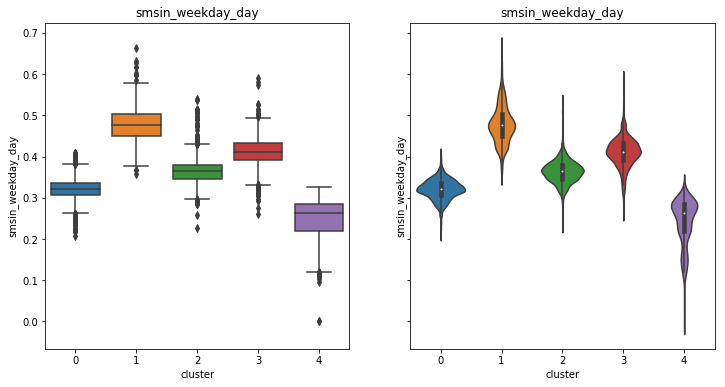

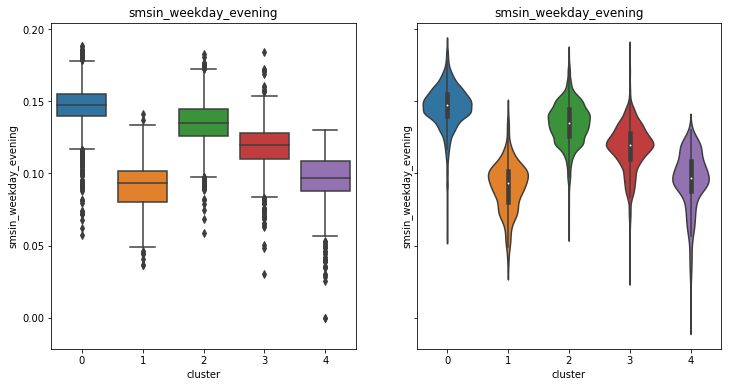

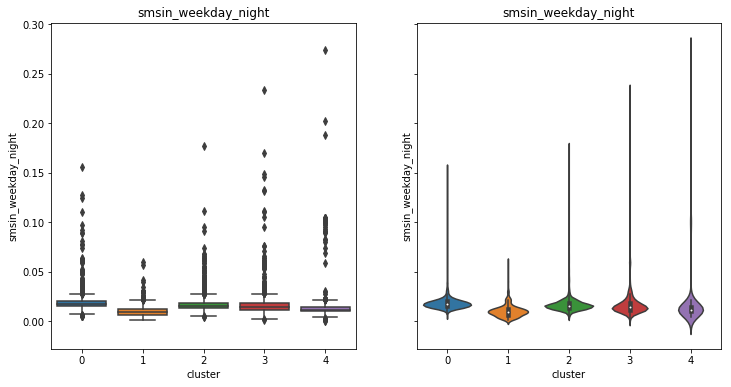

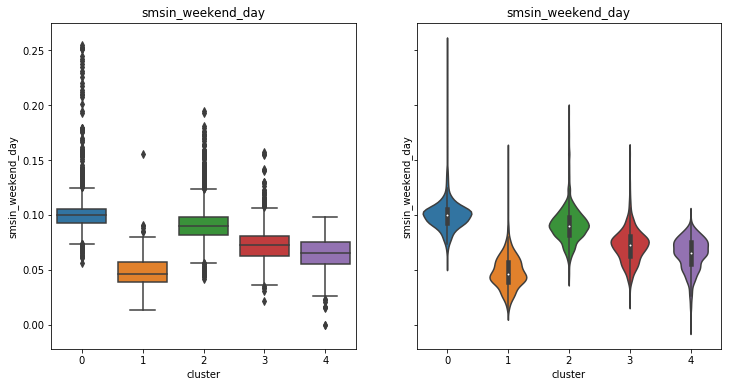

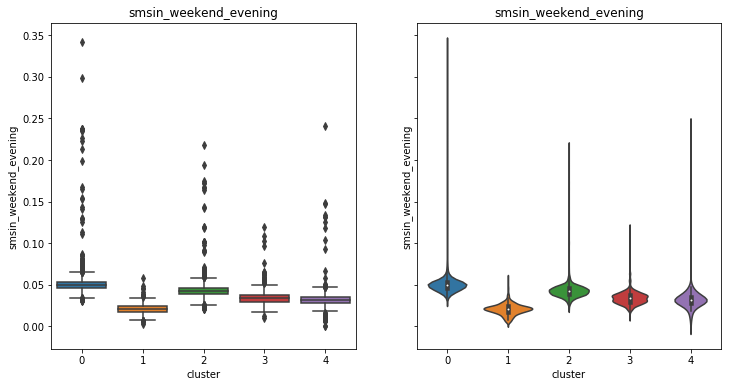

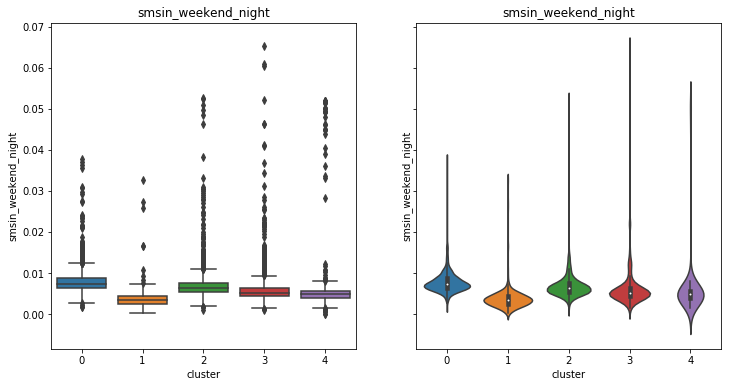

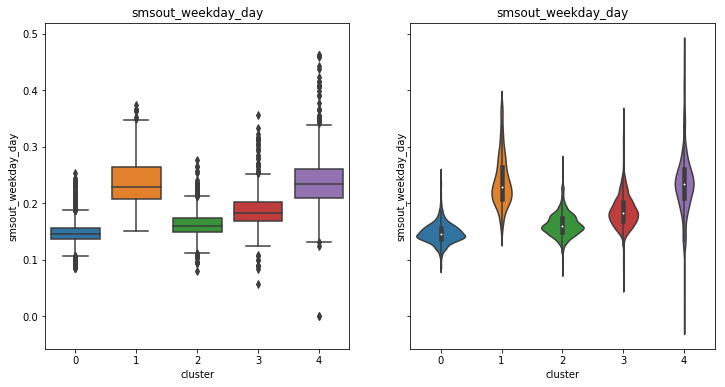

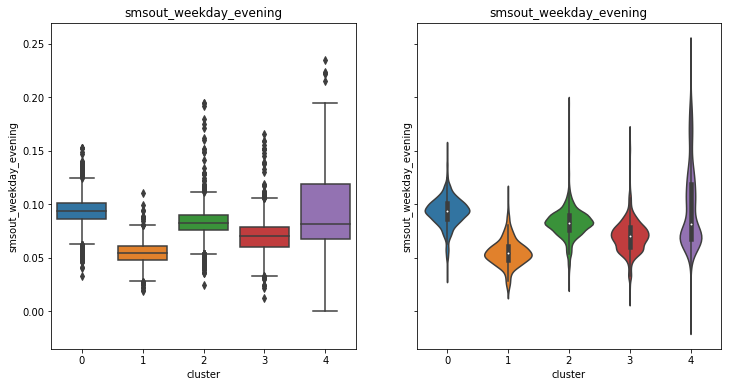

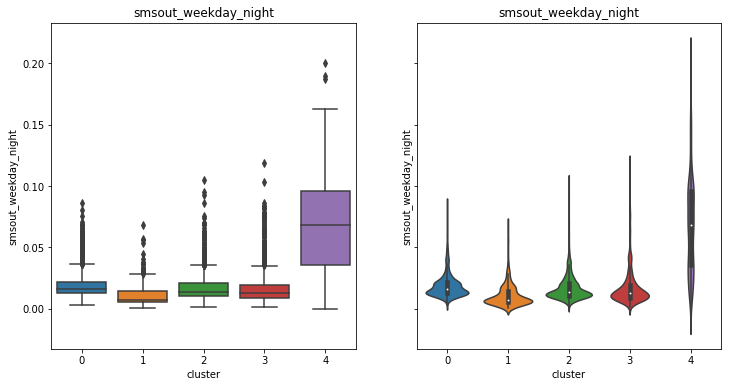

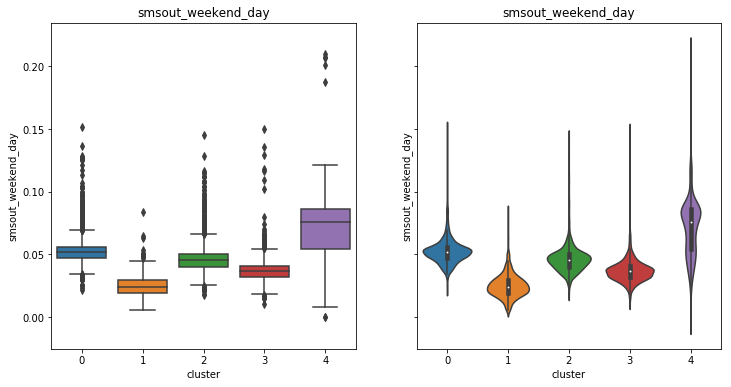

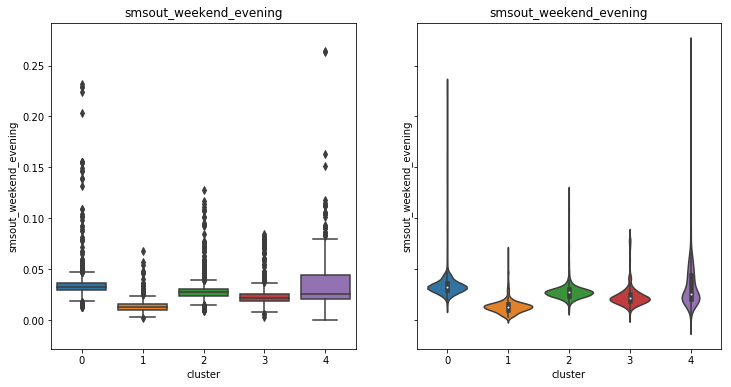

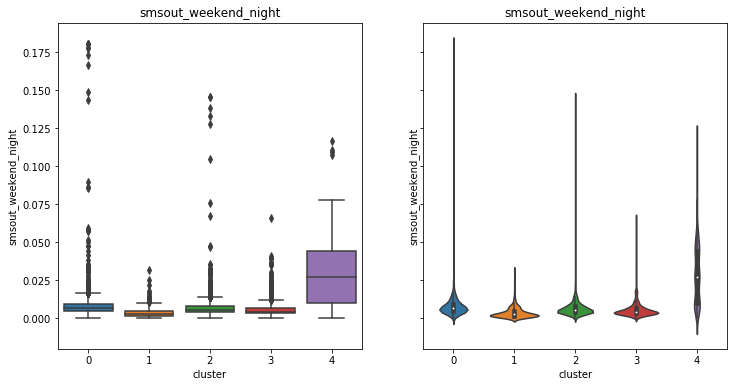

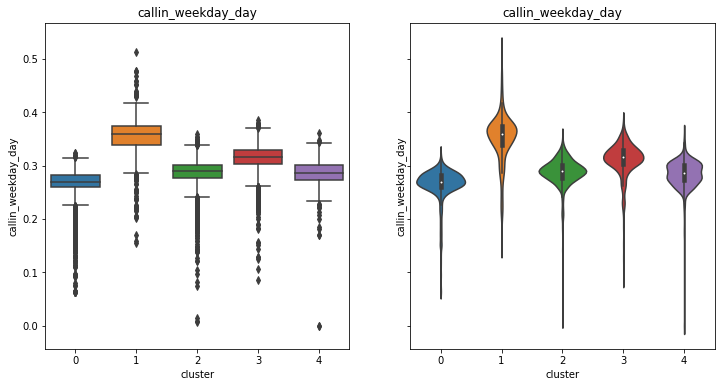

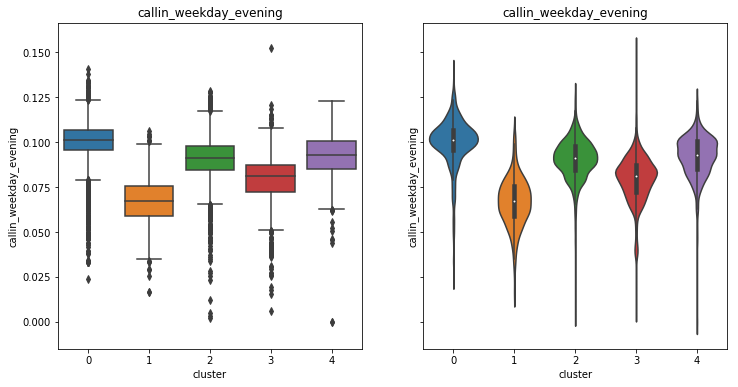

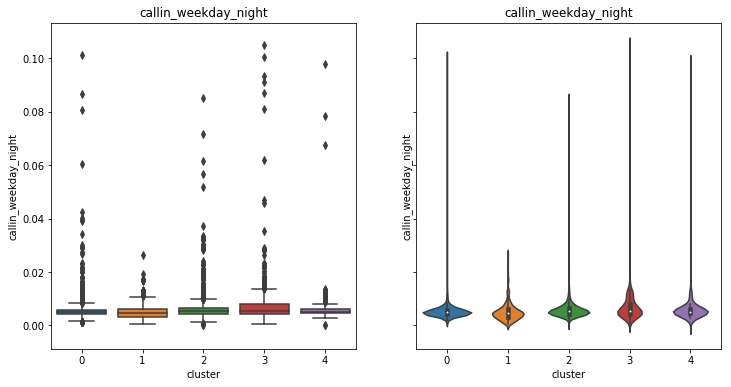

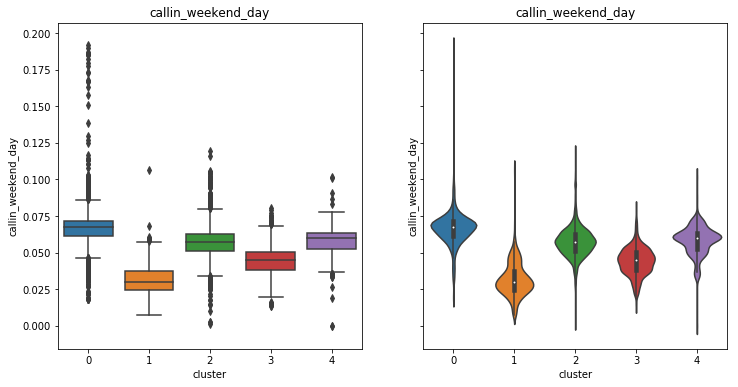

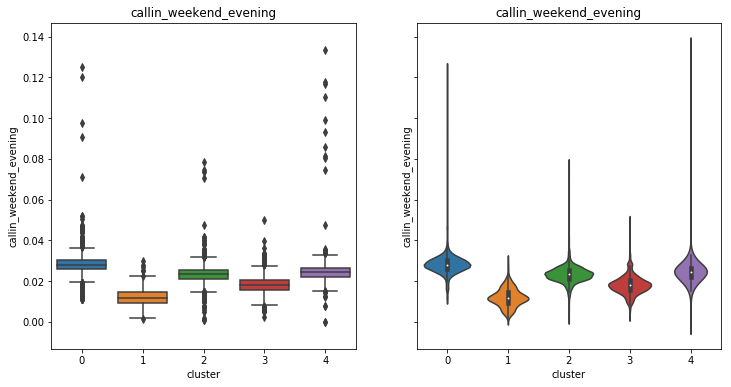

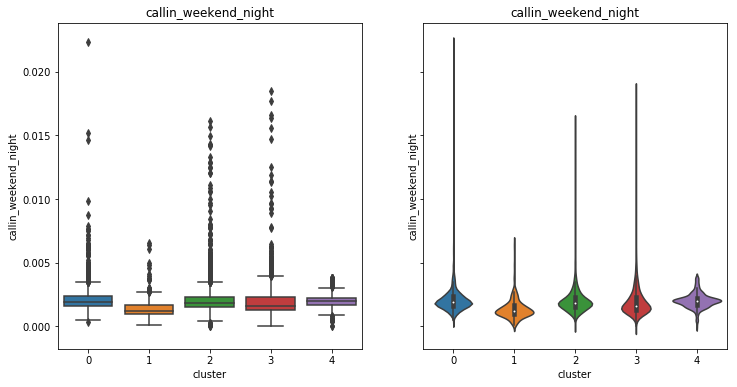

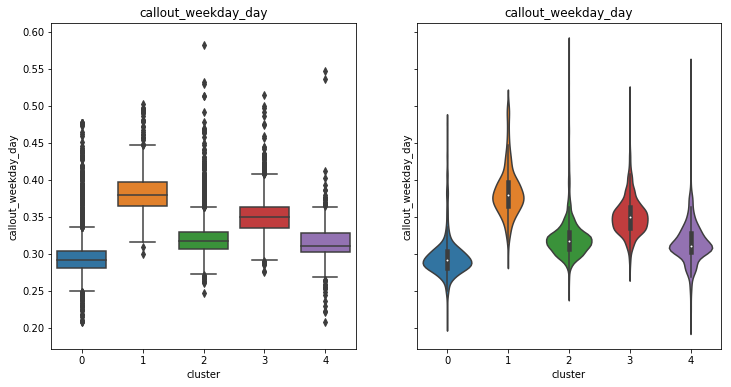

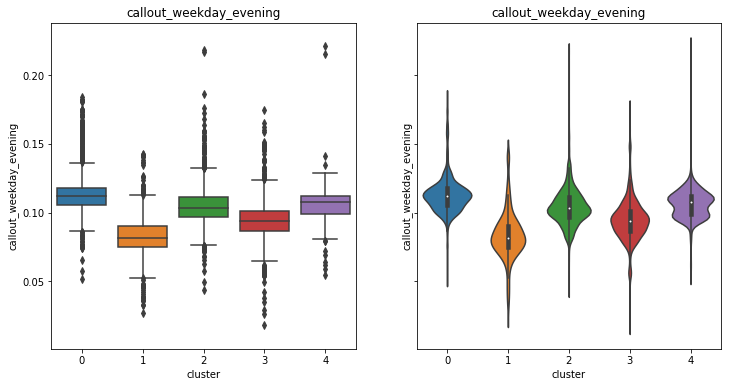

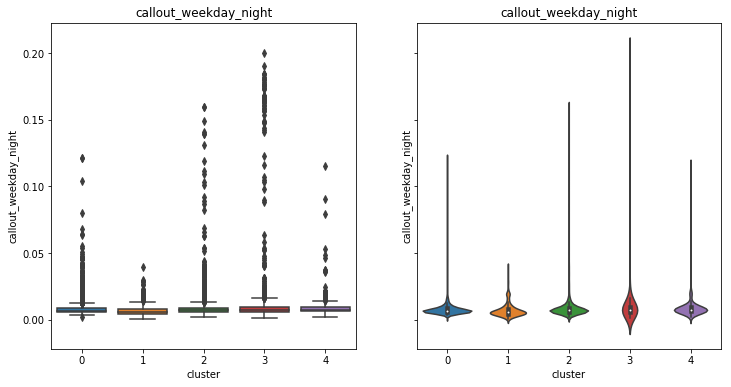

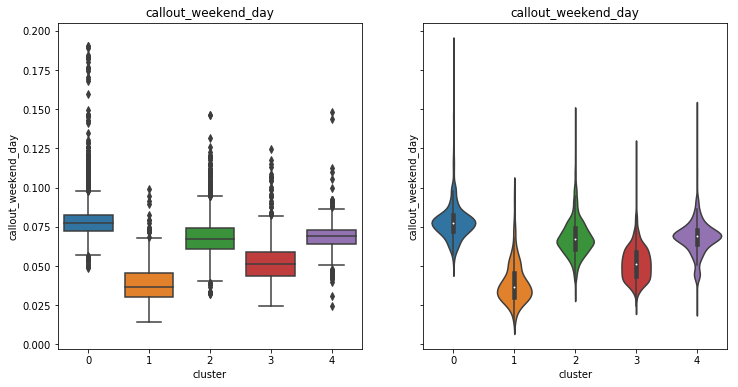

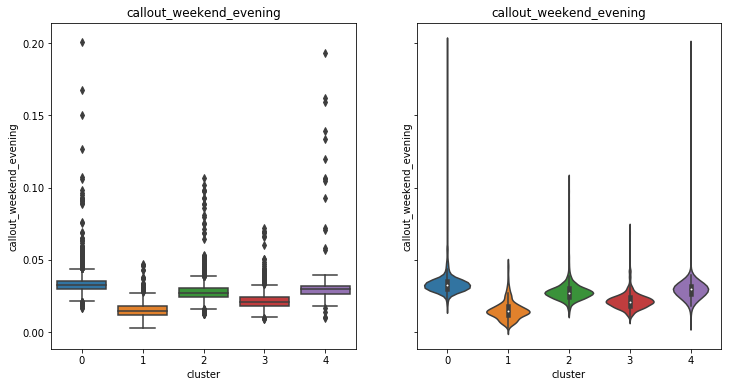

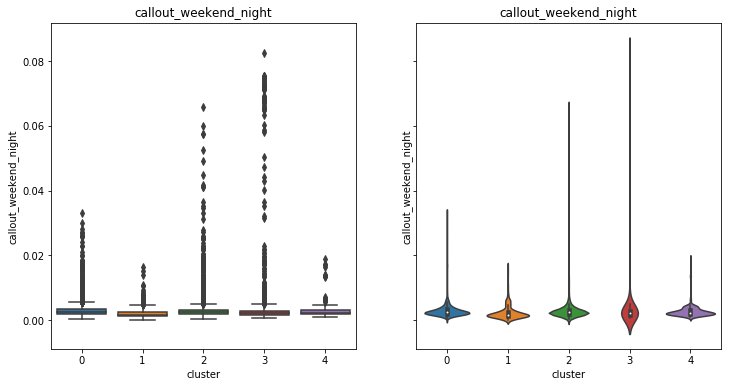

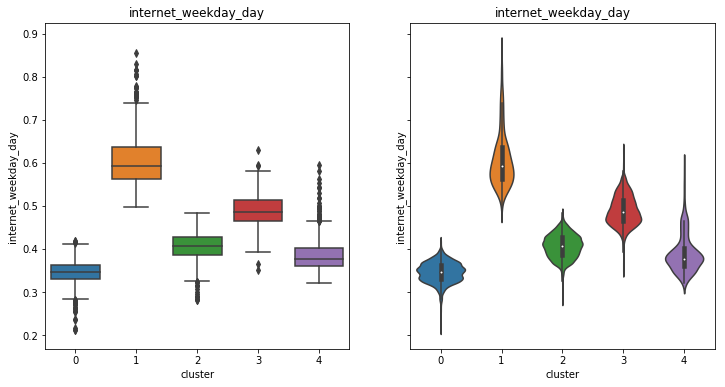

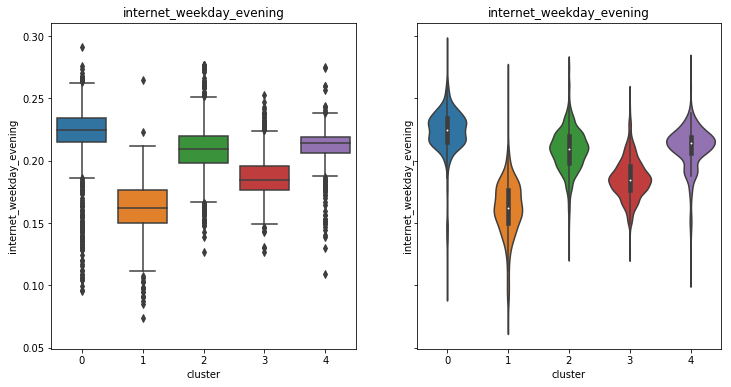

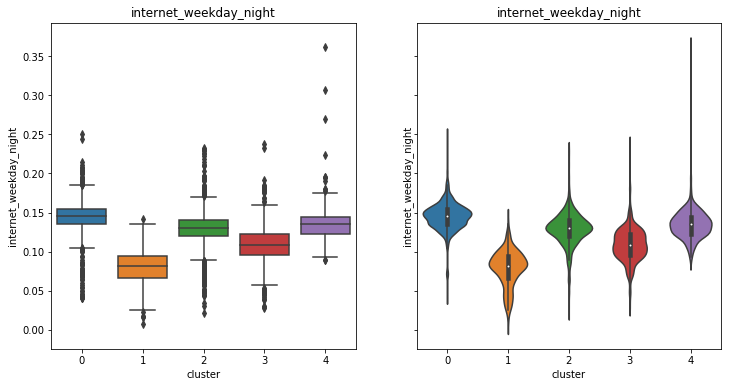

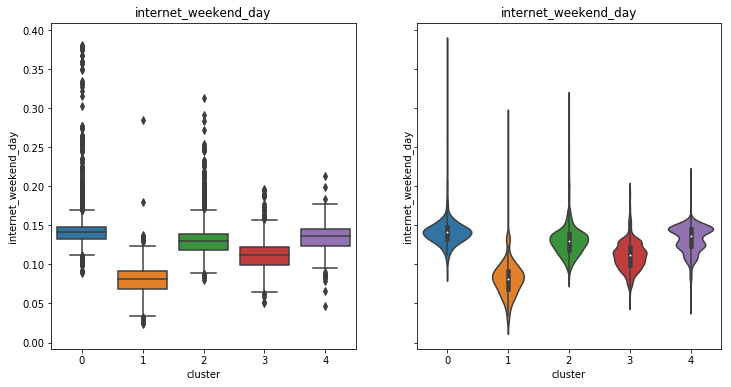

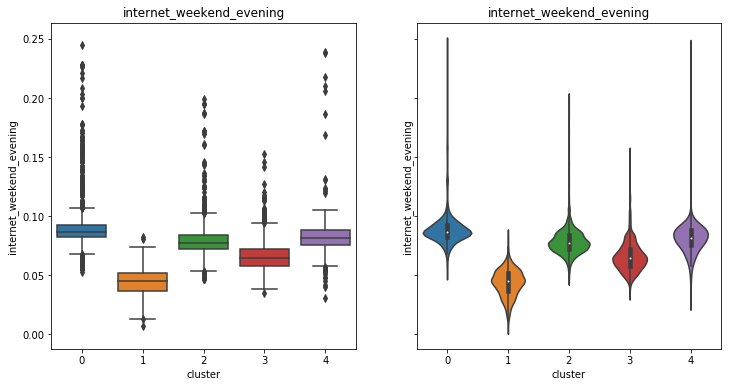

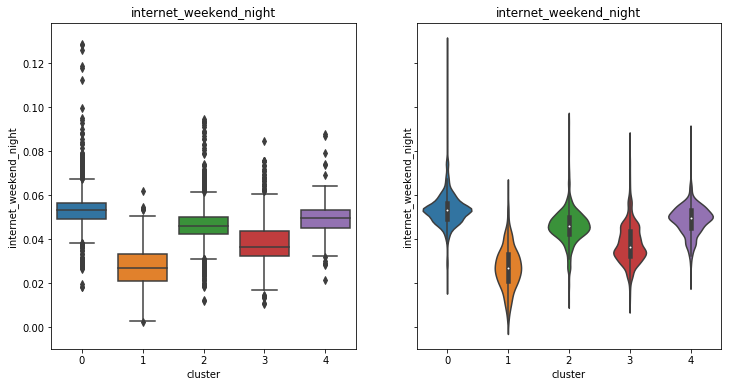

In [24]:
# for each input metric plot a boxplot and violin plot to get a feel for how distributions differ by cluster
for var in df_final.columns[0:30]:
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))
    ax1.set_title(var)
    ax2.set_title(var)
    sns.boxplot(x="cluster", y=var, data=df_final, ax=ax1)
    sns.violinplot(x="cluster", y=var, data=df_final, ax=ax2)

...from the above boxplots we can get a feel for the variables that differ a lot accors clusters and those that don't...

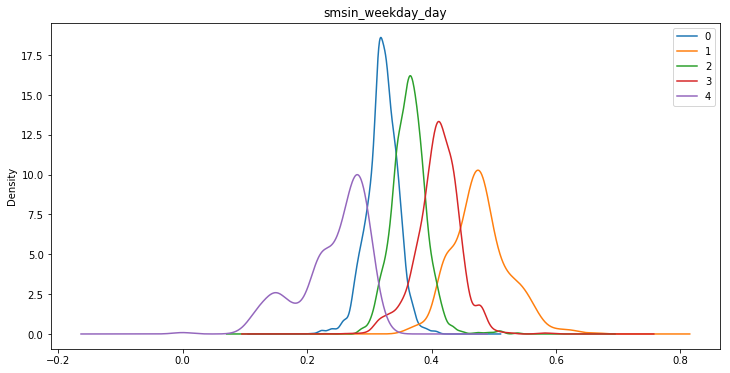

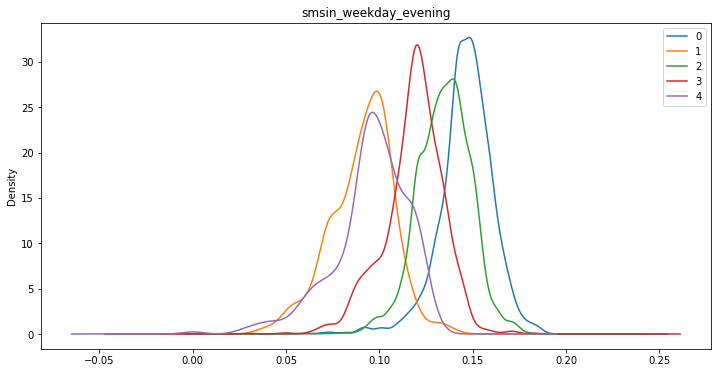

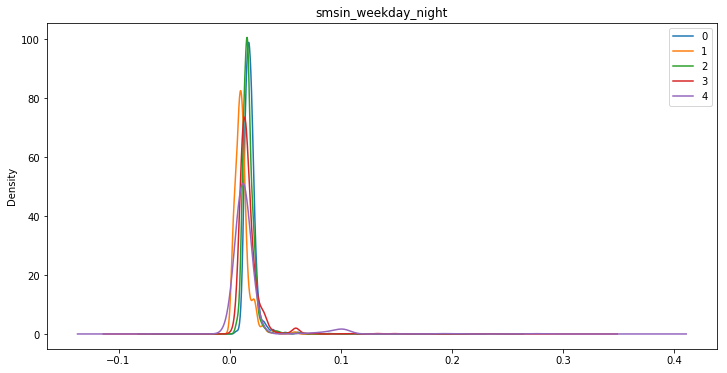

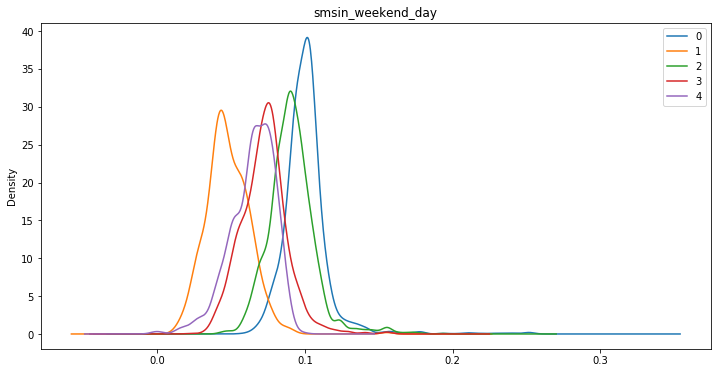

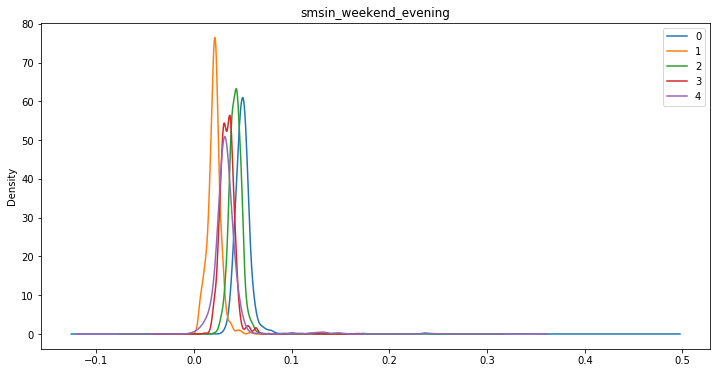

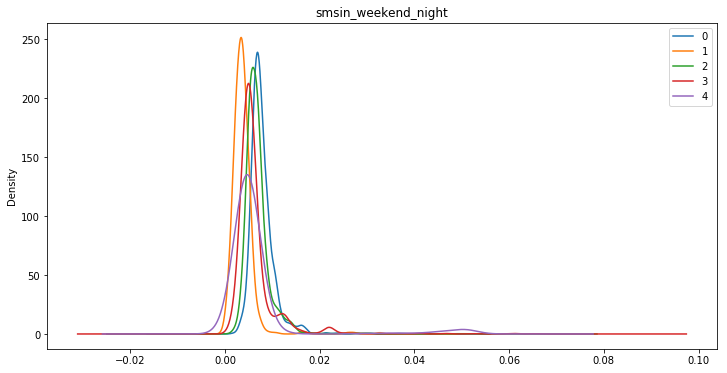

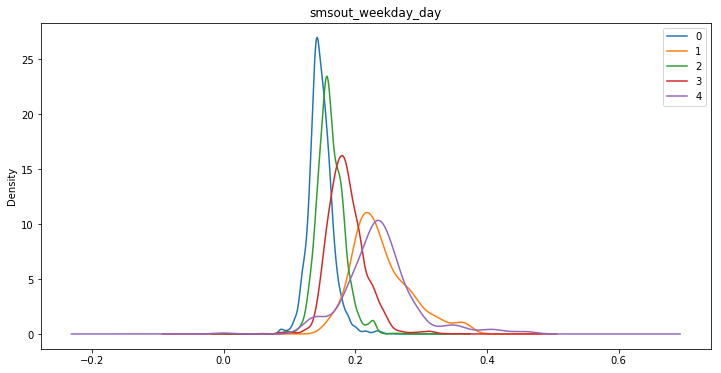

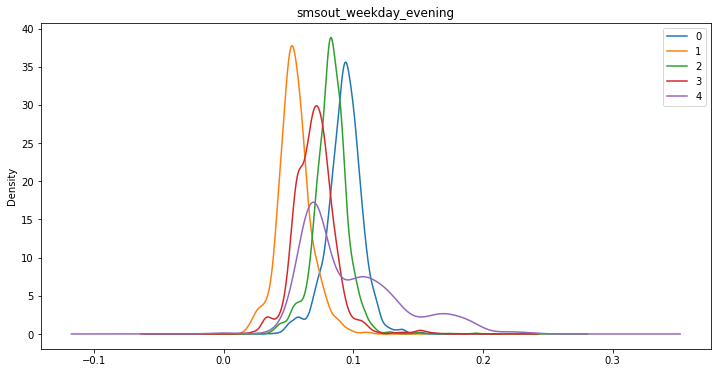

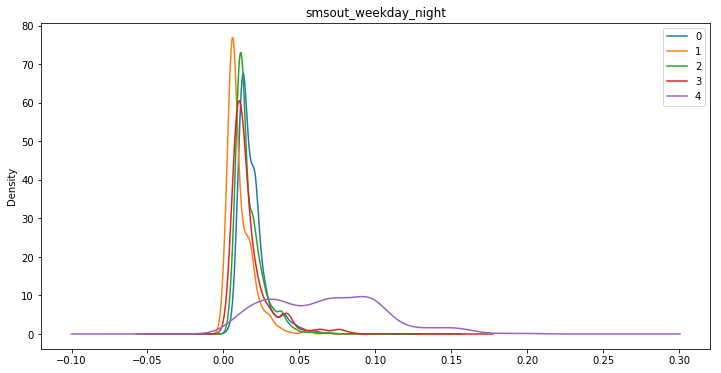

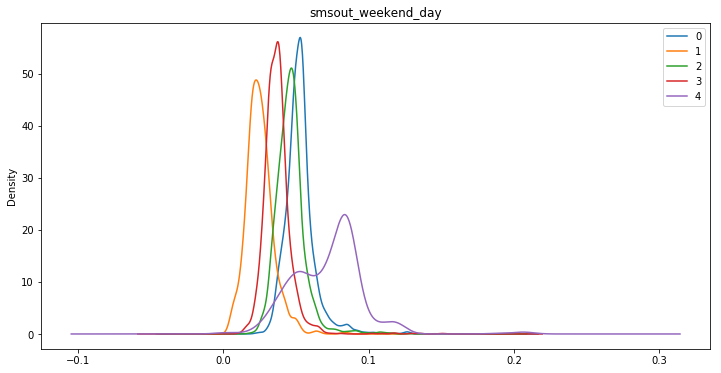

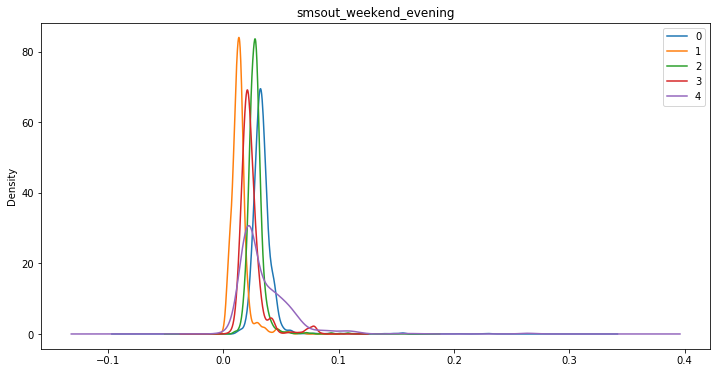

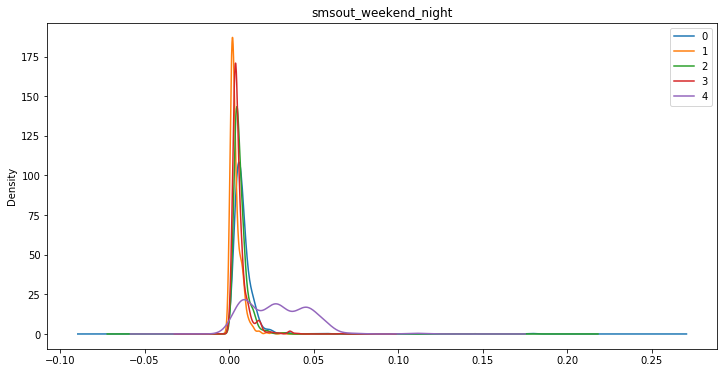

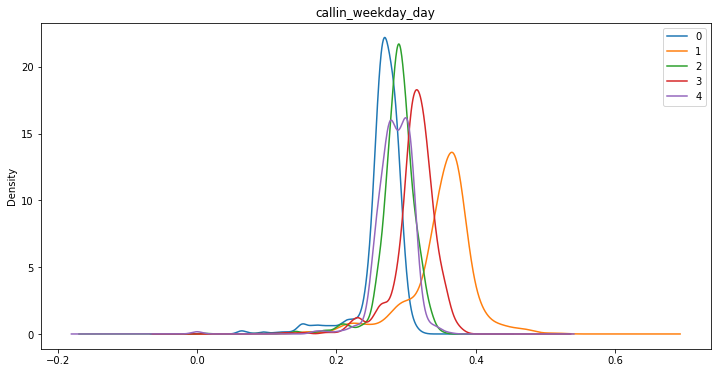

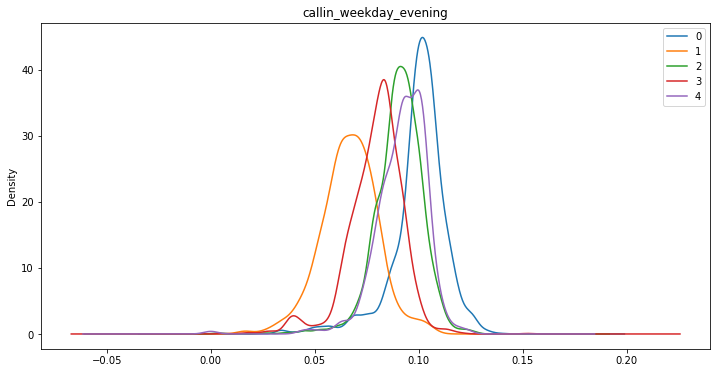

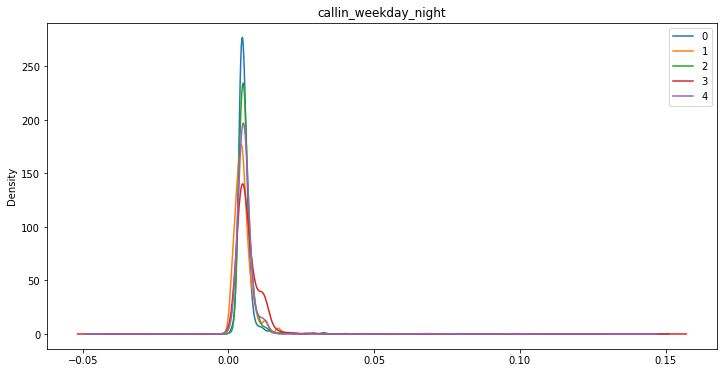

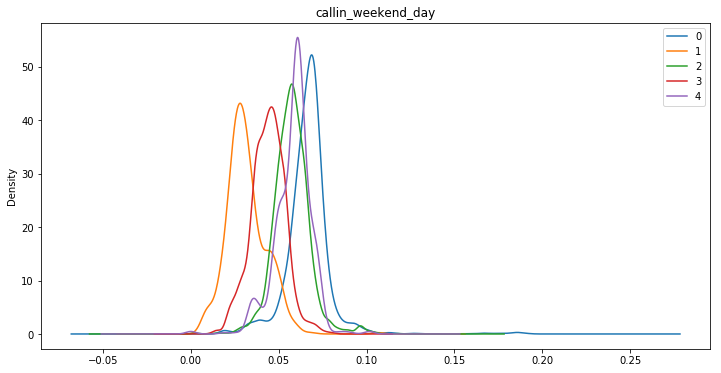

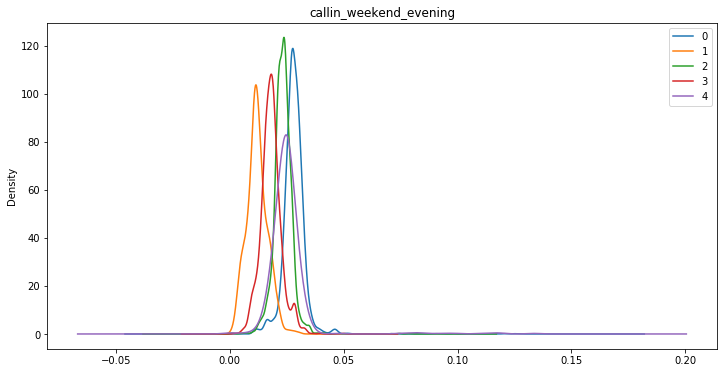

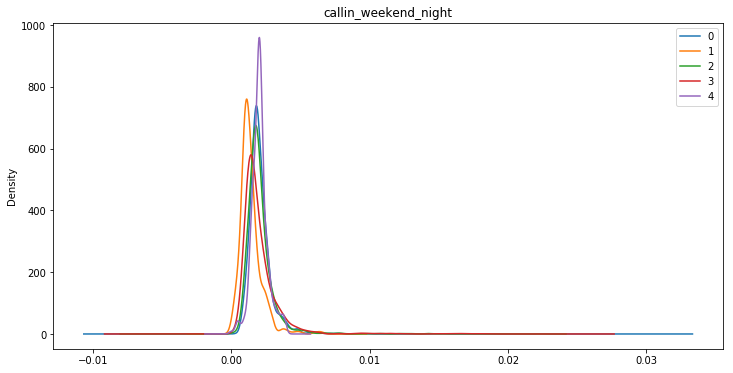

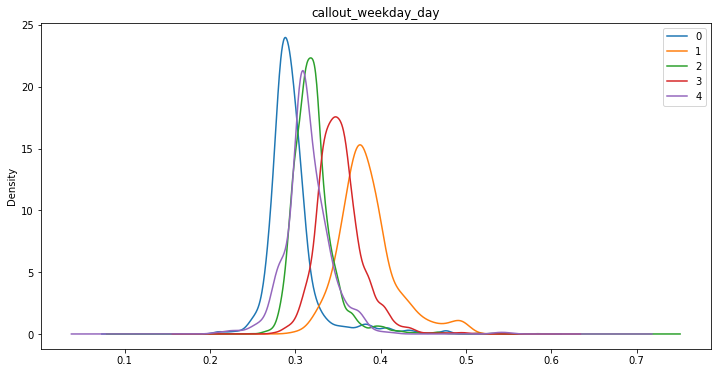

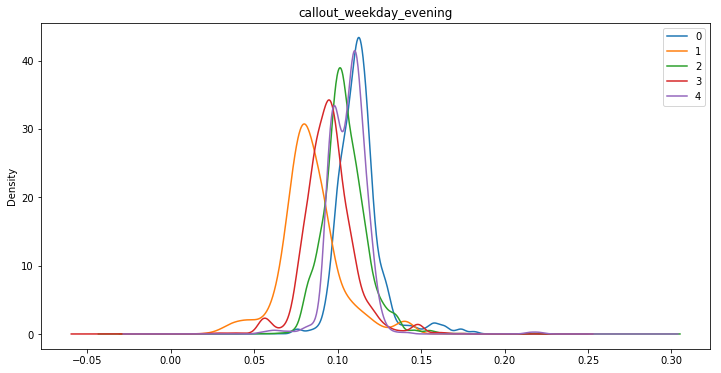

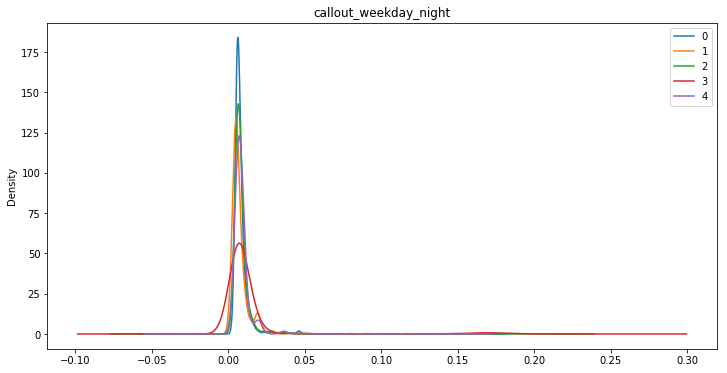

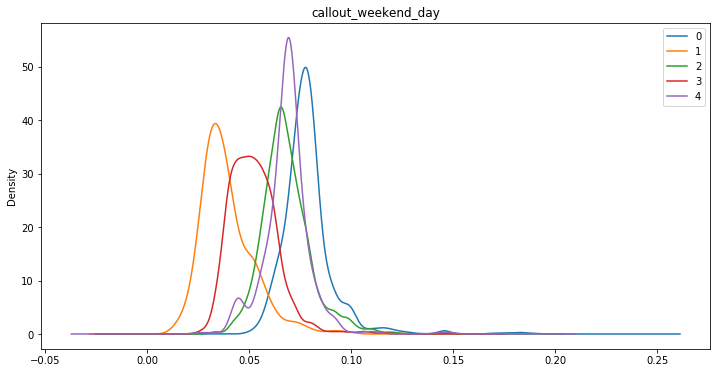

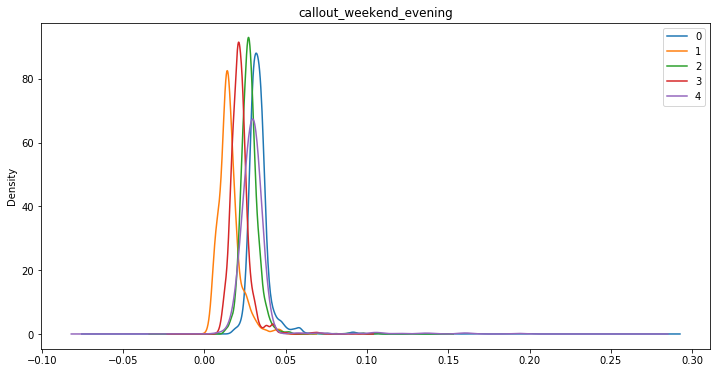

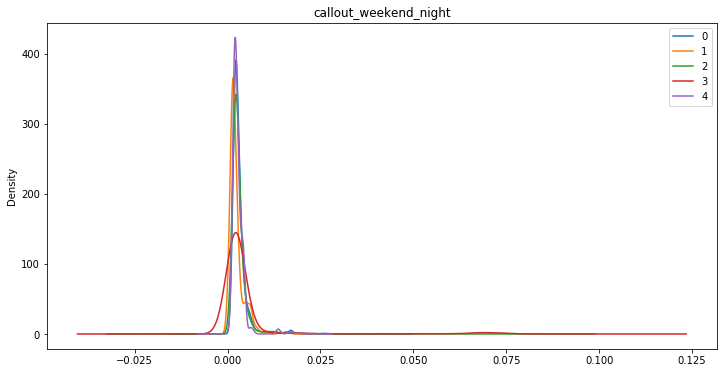

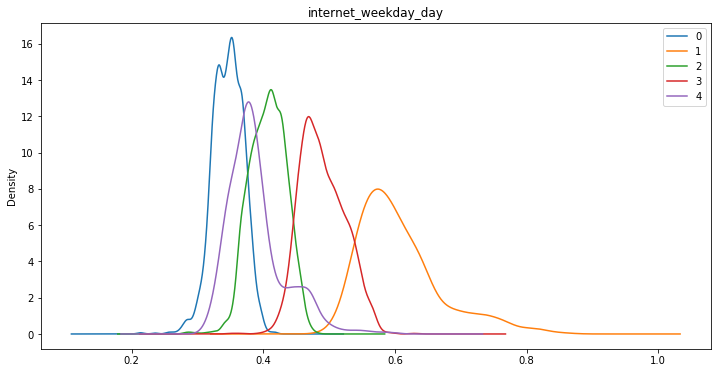

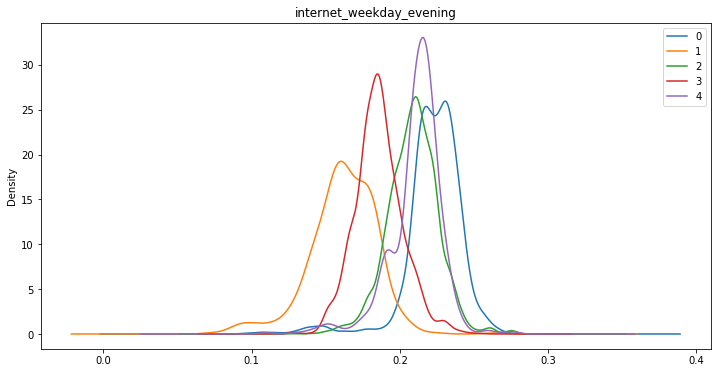

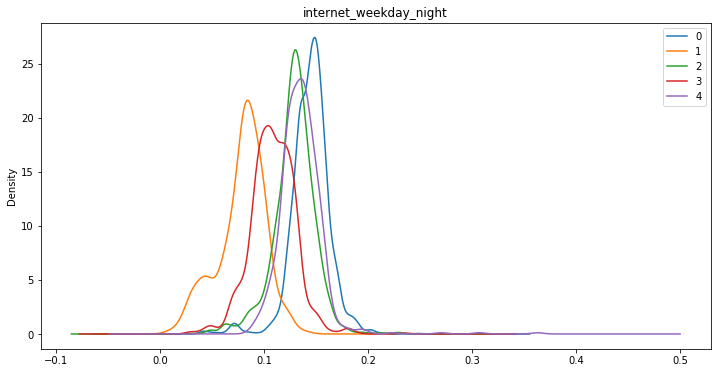

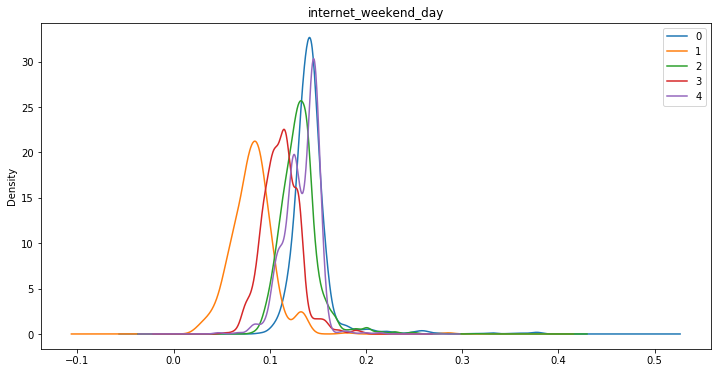

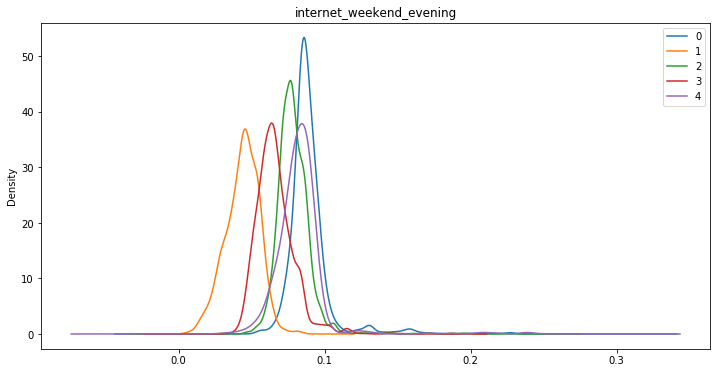

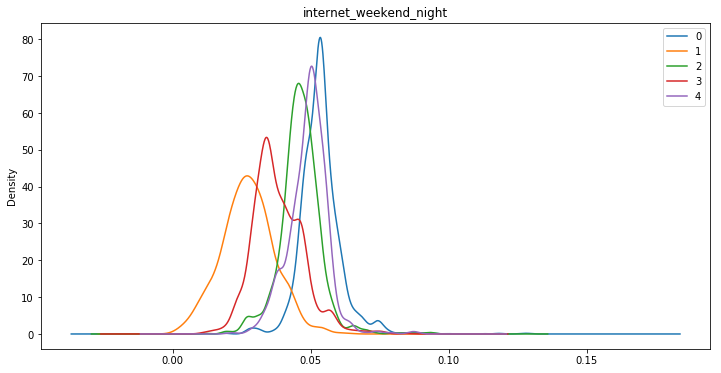

In [25]:
# for each input metric plot a kernel density plot to get a feel for how distributions differ by cluster
for var in df_final.columns[0:30]:
    fig, ax = plt.subplots(figsize=(12,6))
    labels = []
    for key, grp in df_final.groupby(['cluster']):
        ax = grp.plot(ax=ax, kind='kde', x='cluster', y=var)
        labels.append(key)
    lines, _ = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    ax.set_title(var)
    plt.show()

...similar to the box plots the density plots help us get a feel for the variables on which the clusters differ the most or least.

Next we will try and take a more hollistic view and make some point plots for each cluster for each metric. This is a nice quick way to see where some of the main differences in each cluster are. 

To make this plot work however we have to summarise each metric in each cluster. So we will start with the median values of each metric per cluster and then also look at metrics like the mean and different quantile thresholds (to get a feel for the spread).

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

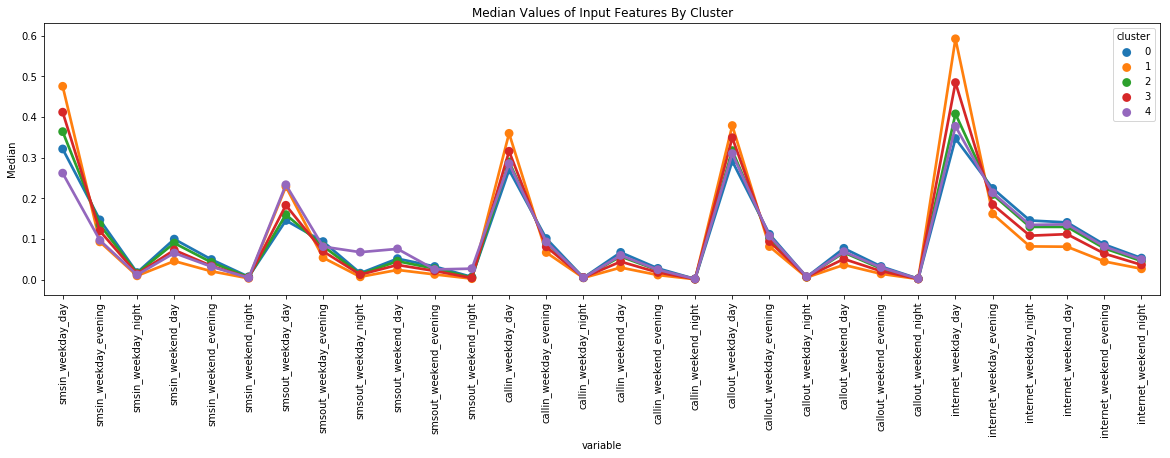

In [26]:
# get a long df giving the median value for each metric for each cluster
df_long = pd.melt(df_final.groupby('cluster', as_index=False).median(), id_vars=['cluster'])
agg_mode = 'Median'
title = 'Median Values of Input Features By Cluster'
plt.figure(figsize=(20,5))
ax = sns.pointplot(x="variable", y="value", hue="cluster", data=df_long, markers='o', linestyles='-')
ax.set_ylabel(agg_mode)
ax.set_title(title)
plt.xticks(rotation=90)

...so for example, from the above plot we can see that the main metric the clusters differ on is "internet_weekday_day" ranging from around 30% to 60%.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

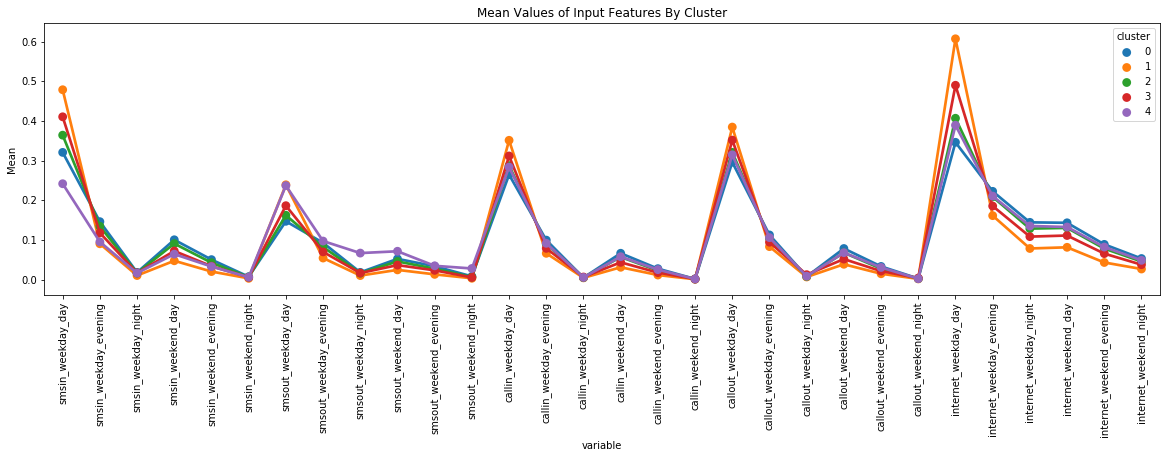

In [27]:
# same as above but look at averages
df_long = pd.melt(df_final.groupby('cluster', as_index=False).mean(), id_vars=['cluster'])
agg_mode = 'Mean'
title = 'Mean Values of Input Features By Cluster'
plt.figure(figsize=(20,5))
ax = sns.pointplot(x="variable", y="value", hue="cluster", data=df_long, markers='o', linestyles='-')
ax.set_ylabel(agg_mode)
ax.set_title(title)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

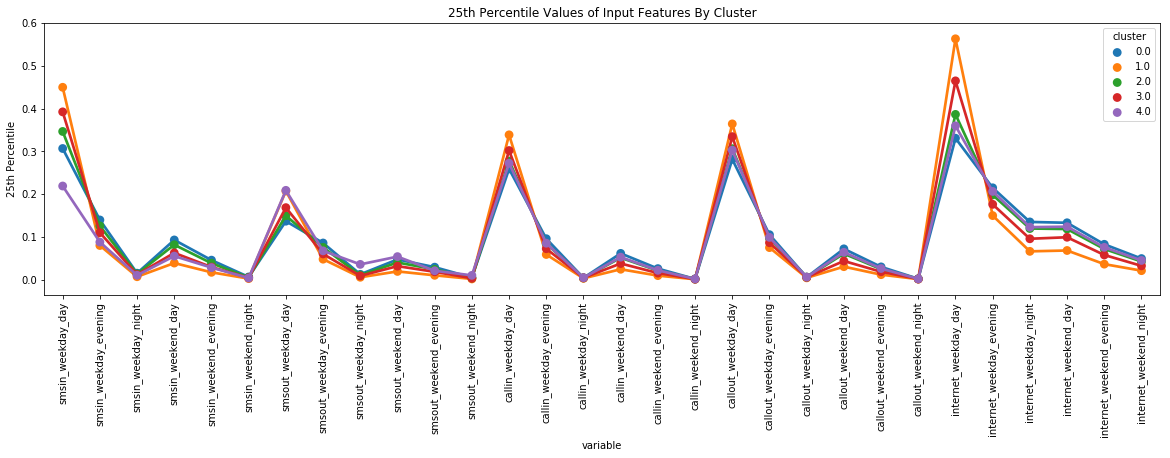

In [28]:
# 25th percentile
df_long = pd.melt(df_final.groupby('cluster', as_index=False).quantile(.25), id_vars=['cluster'])
df_long.columns = ['cluster','variable','value']
agg_mode = '25th Percentile'
title = '25th Percentile Values of Input Features By Cluster'
plt.figure(figsize=(20,5))
ax = sns.pointplot(x="variable", y="value", hue="cluster", data=df_long, markers='o', linestyles='-')
ax.set_ylabel(agg_mode)
ax.set_title(title)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

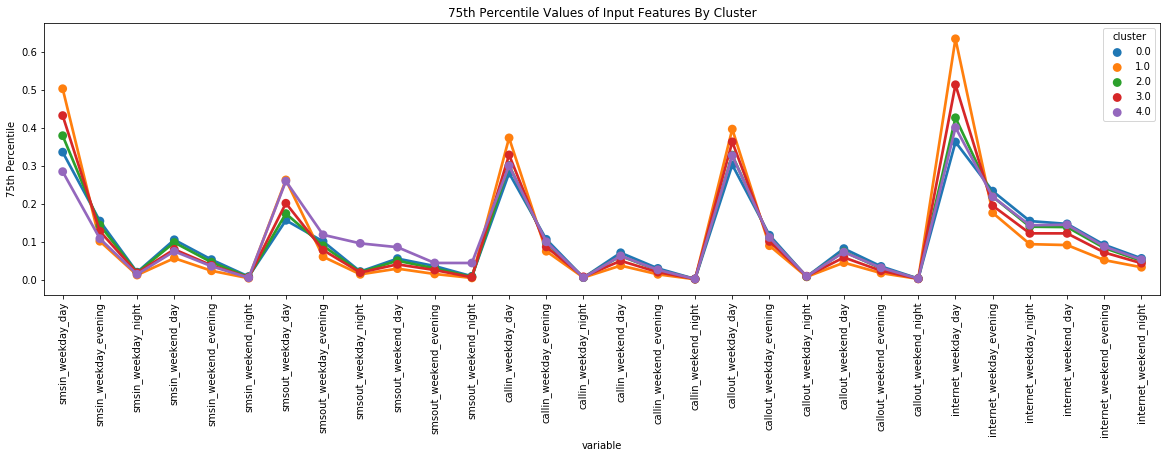

In [29]:
# 75th percentile
df_long = pd.melt(df_final.groupby('cluster', as_index=False).quantile(.75), id_vars=['cluster'])
df_long.columns = ['cluster','variable','value']
agg_mode = '75th Percentile'
title = '75th Percentile Values of Input Features By Cluster'
plt.figure(figsize=(20,5))
ax = sns.pointplot(x="variable", y="value", hue="cluster", data=df_long, markers='o', linestyles='-')
ax.set_ylabel(agg_mode)
ax.set_title(title)
plt.xticks(rotation=90)

### Look at summary stats for each cluster visually

Next lets look at each cluster on its own and plot similar metrics but just for one cluster at a time so we can get a feel for the range of values within each cluster...

In [30]:
# make lots of long summary stat tables for each metric and cluster
df_long_10 = pd.melt(df_final.groupby('cluster', as_index=False).quantile(.1), id_vars=['cluster'])
df_long_10.columns = ['cluster','variable','value']
df_long_10['metric'] = '10th Percentile'
df_long_25 = pd.melt(df_final.groupby('cluster', as_index=False).quantile(.25), id_vars=['cluster'])
df_long_25.columns = ['cluster','variable','value']
df_long_25['metric'] = '25th Percentile'
df_long_50 = pd.melt(df_final.groupby('cluster', as_index=False).quantile(.50), id_vars=['cluster'])
df_long_50.columns = ['cluster','variable','value']
df_long_50['metric'] = '50th Percentile'
df_long_75 = pd.melt(df_final.groupby('cluster', as_index=False).quantile(.75), id_vars=['cluster'])
df_long_75.columns = ['cluster','variable','value']
df_long_75['metric'] = '75th Percentile'
df_long_90 = pd.melt(df_final.groupby('cluster', as_index=False).quantile(.75), id_vars=['cluster'])
df_long_90.columns = ['cluster','variable','value']
df_long_90['metric'] = '90th Percentile'

In [31]:
# union all the stats data together
df_long_stats = df_long_10.append([df_long_25,df_long_50,df_long_75,df_long_90])

print(df_long_stats.shape)
df_long_stats.sample(5)

(750, 4)


cluster                  variable     value           metric
91       1.0       callout_weekday_day  0.397584  75th Percentile
129      4.0  internet_weekday_evening  0.189089  10th Percentile
67       2.0    callin_weekday_evening  0.097793  90th Percentile
68       3.0    callin_weekday_evening  0.080979  50th Percentile
71       1.0      callin_weekday_night  0.006182  90th Percentile

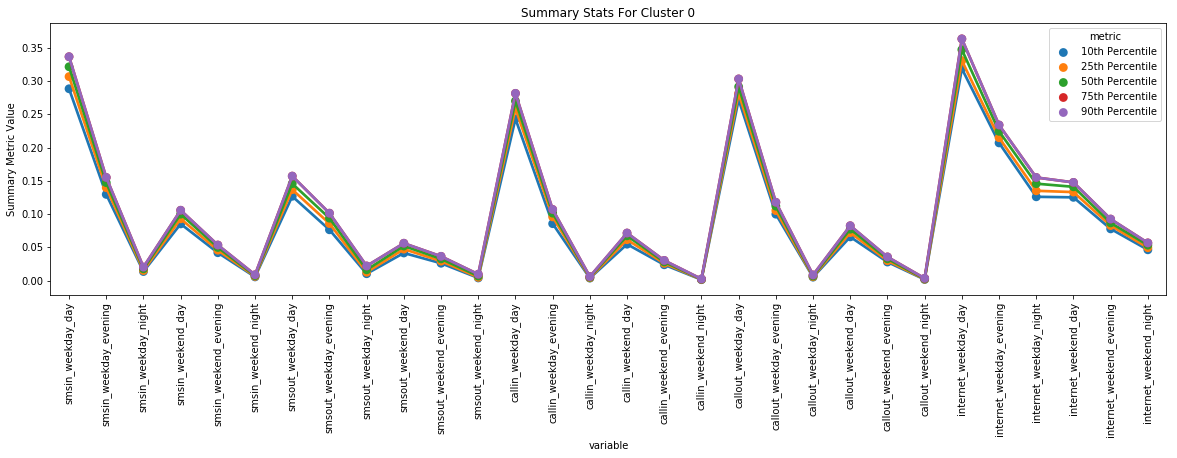

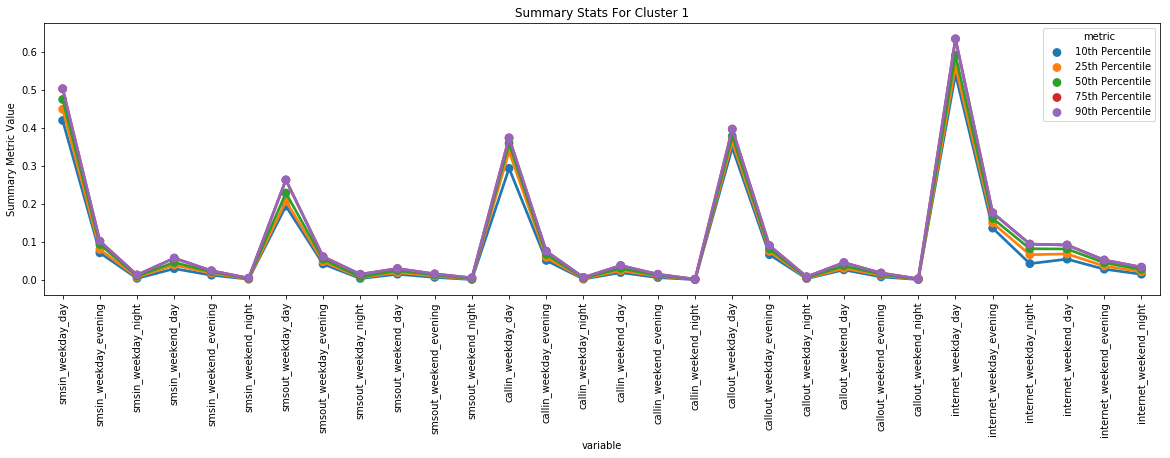

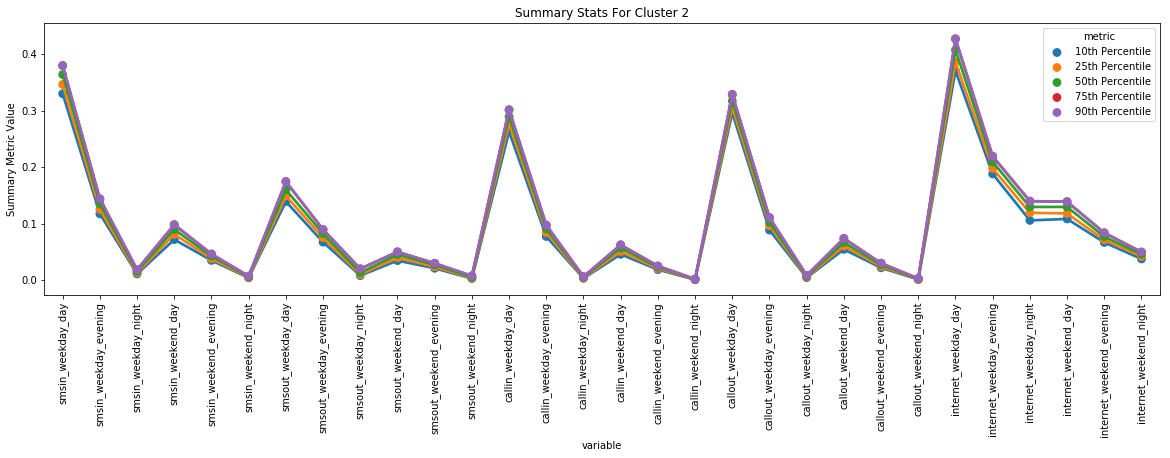

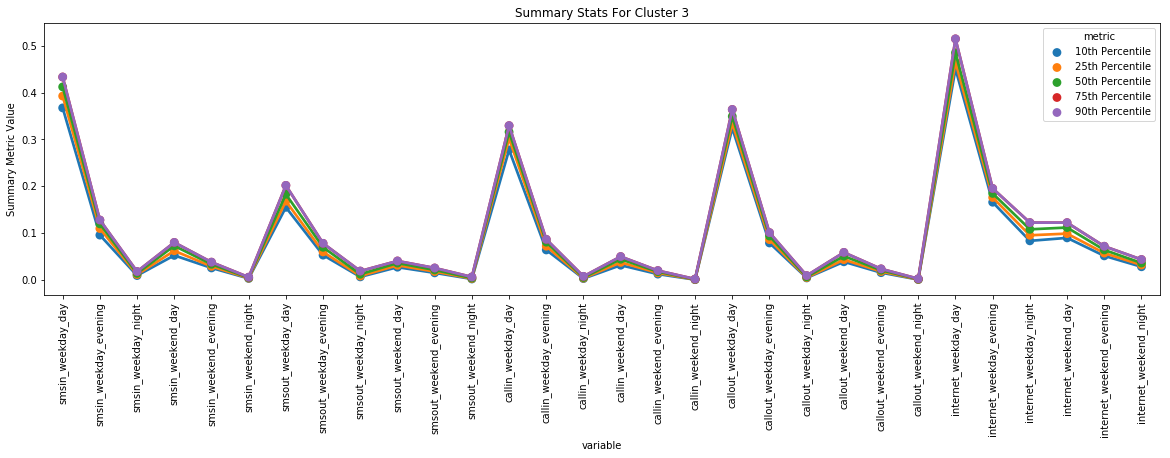

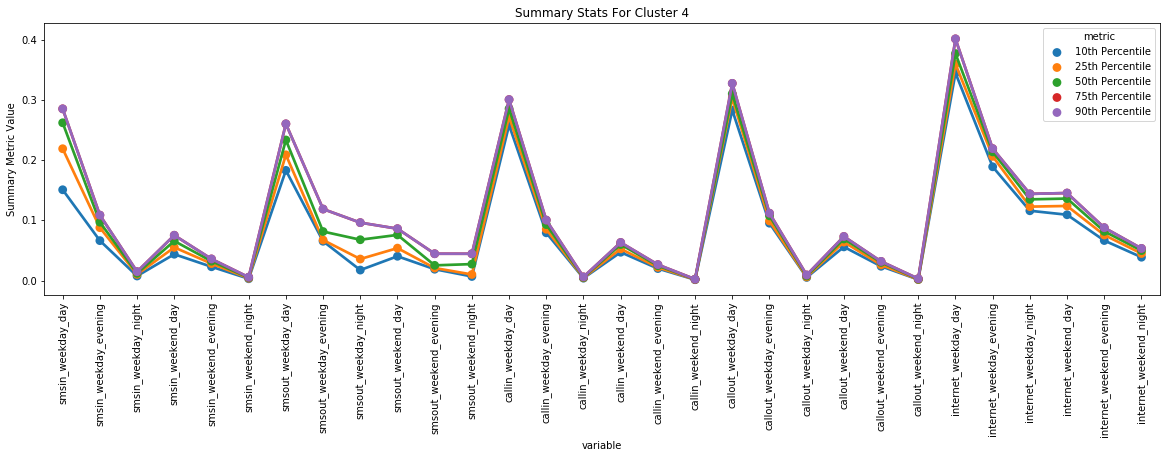

In [35]:
# now loop through each cluster and plot the summary stats for each metric
for c in np.unique(clusterer.labels_): 
    df_long = df_long_stats[(df_long_stats.cluster == c)]
    agg_mode = 'Summary Metric Value'
    title = 'Summary Stats For Cluster ' + str(c)
    plt.figure(figsize=(20,5))
    ax = sns.pointplot(x="variable", y="value", hue="metric", data=df_long, markers='o', linestyles='-')
    ax.set_ylabel(agg_mode)
    ax.set_title(title)
    plt.xticks(rotation=90)
    plt.show()

...from the above plots we can get a sense for the variance within each metric for each cluster by seeing the spread of the different percentile lines. 

## Plot Clusters On Map

Finally we will plot the cluster on the actual cell grid map to see if any interesting geo spatial patterns jump out. 

In [36]:
# load in the geo json data
with open(MY_DIR + "\\milano-grid.geojson") as json_file:
    json_data = geojson.load(json_file)

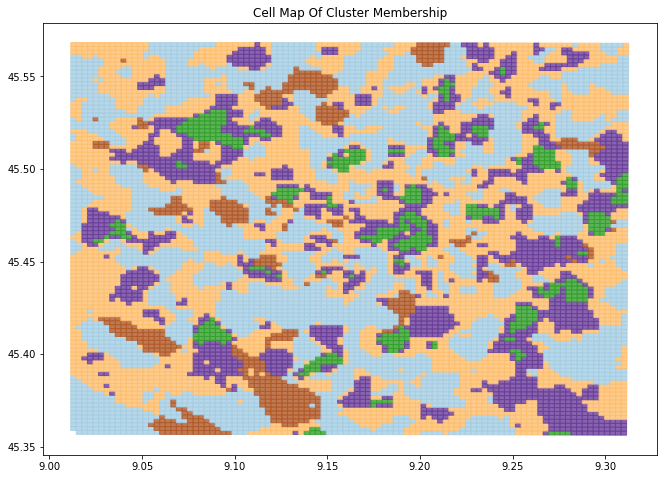

In [37]:
fig = plt.figure() 
ax = fig.gca() 

# some things to handle the coloring
jet = cm = plt.get_cmap('Paired') 
cNorm  = colors.Normalize(vmin=0, vmax=clusterer.labels_.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# go through each cell and color it by cluster
for i in range(1,len(json_data.features)):
    
    # put a try block in in case can't find some cells in the cluster data for some reason.
    
    try:
        poly = json_data.features[i]['geometry']
        cell_id = str(json_data.features[i]['properties']['cellId'])
        cluster = df_final.loc[cell_id]['cluster']
        colorVal = scalarMap.to_rgba(cluster)
        
        # add patch to the map
        ax.add_patch(PolygonPatch(poly, fc=colorVal, ec=colorVal, alpha=0.8, zorder=1 ))
        
    except:
        pass

ax.axis('scaled')

fig.set_size_inches(11,11)
plt.title("Cell Map Of Cluster Membership")
plt.show()

The most interesting thing about this map is that there does indeed seem to be spatial patterns here with nearby cells tending to be in the same cluster and 'blobs' of clusters seeming to have formed. This is nice to see as if this were not the case then that would raise suspisions on the clustering approach as having done anything much different to a random assignment.

To illustrate this point a bit we will do the same chart as above but with a random clusrter assignemnt to illustrate the difference...

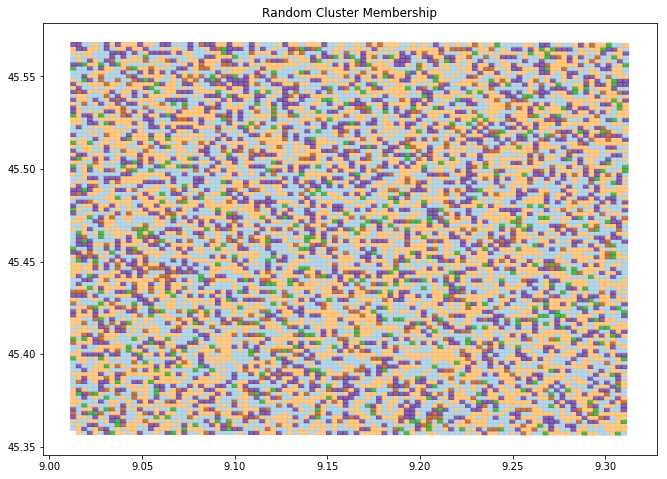

In [39]:
fig = plt.figure() 
ax = fig.gca() 

# some things to handle the coloring
jet = cm = plt.get_cmap('Paired') 
cNorm  = colors.Normalize(vmin=0, vmax=clusterer.labels_.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# go through each cell and color it by cluster
for i in range(1,len(json_data.features)):
    
    # put a try block in in case can't find some cells in the cluster data for some reason.
    
    try:
        poly = json_data.features[i]['geometry']
        cell_id = str(json_data.features[i]['properties']['cellId'])
        #cluster = df_final.loc[cell_id]['cluster']
        cluster = np.random.choice(clusterer.labels_,1)[0] # randomly pick a cluster
        colorVal = scalarMap.to_rgba(cluster)
        
        # add patch to the map
        ax.add_patch(PolygonPatch(poly, fc=colorVal, ec=colorVal, alpha=0.8, zorder=1 ))
        
    except:
        pass

ax.axis('scaled')

fig.set_size_inches(11,11)
plt.title("Random Cluster Membership")
plt.show()

## Conclusions

It looks like we have found some clear structure in the cell data, however the differneces between the clusters are more a measure of magnitude as opposed to completley different behaviour types as such. 

So i'd probably continue to iterate a bit more to see if we can tinker with the representation to get a 'nicer' clustering. Some things i'd try might be:

* Use daily features as opposed to weekend vs weekday.
* Try some more granular time slicing of the day.
* Explore some more flexible clustering approaches like DBSCAN or maybe hierarchical clustering (more computational expensive). 

Of course it could be that after all this we still see similar results in terms of finding some clusters that look like slight variants of each other as opposed completley different ones. Thats the thing about clustering and unsupervised methods - you never really know what to expect. 